
# <font size="+3"><span style='color:#2994ff'> **P5 - Segmentez des clients d'un site e-commerce** </span></font>


<a id='LOADING_LIBRARIES'></a>

---

---

<font size="+1"> **LOADING THE LIBRARIES** </font>

---

In [1]:

# ----------------
# Packages Update
# ----------------
# !pip install --upgrade sklearn
# !pip install Jinja2

# General libraries
import os
import glob
import pandas as pd
import numpy as np
import csv
from pprint import pprint
import time
from collections import Counter
from math import pi

# Data preprocessing
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

# Clustering
from sklearn import cluster, metrics
from sklearn import decomposition
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import statistics


# Data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly as plotly
import plotly.express as px
import plotly.graph_objects as go
import squarify
import scipy.stats as stats
%pylab inline

# Validation code PEP8
%load_ext pycodestyle_magic
%pycodestyle_on

# Warnings
import warnings
from warnings import simplefilter
warnings.filterwarnings(action='once')
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=ValueError)
simplefilter(action='ignore', category=UserWarning)


'''
# -------------------------------------------------------------
# Checking the version numbers of the installed packages
# -------------------------------------------------------------
'''
print('Librairies version : \n')
print('Pandas      : ' + pd.__version__)
print('NumPy       : ' + np.version.full_version)
print('Csv         : ' + csv.__version__ + '\n')
print('Matplotlib  : ' + mpl.__version__)
print('Seaborn     : ' + sns.__version__ + '\n')
print('Sklearn     : ' + sklearn.__version__)

import datetime
now = datetime.datetime.now().isoformat()
print('Launched on      : ' + now)

Populating the interactive namespace from numpy and matplotlib
Librairies version : 

Pandas      : 1.5.3
NumPy       : 1.23.5
Csv         : 1.0

Matplotlib  : 3.7.1
Seaborn     : 0.12.2

Sklearn     : 1.0.2
Launched on      : 2023-04-18T18:30:27.940315


/home/raquelsp/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['pi']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
%pycodestyle_off


<a id='USED_PARAMETERS'></a>


<br>


---
---

<font size="+1"> **PARAMETERS USED IN THIS NOTEBOOK** </font>

---


In [3]:
# Parameters used in this notebook

palette4 = ["#253d85", "#618576", "#cba87d", "#faec4d"]

palette5 = ["#253d85", "#618576", "#9595b1", "#cba87d", "#faec4d"]

palette6 = ["#253d85", "#618576", "#9595b1", "#cba87d", "#dcd2a3", "#faec4d"]


<a id='USED_FUNCTIONS'></a>


<br>


---
---

<font size="+1"> **FUNCTIONS USED IN THIS NOTEBOOK** </font>

---


In [4]:
# ----------------------------
# CLUSTER EVOLUTION OVER TIME
# ----------------------------

def rfm_RS_cluster_evolution(dataframe, dataframe_result,
                               date_hist, title, num_clusters):
    """
    Customers segmentation from a date + stability metrics
    ----------
    @ Parameters
    * dataframe : dataframe to analyse
    * dataframe_result : dataframe for saving ARI scores
    * date_hist : Date for cluster analysis (t1), more recent than the
                reference date, string in the format 'YYYY-MM-DD HH24:MI:SS'
    * title : corresponds to the historial period for the dataframe for ARI
              scores saving, format  X_months_NameMonthStart_NameMonthEnd
    * num_clusters : number of clusters
    -------
    @ Returns
    * dataframe_result : dataframe for saving ARI scores
    * df_scaled_hist : the Kmeans segmentation dataframe on the historical
                        period
    """

    date = []
    interval = []
    ari_score = []
    # -----------------------
    # Dataframes preparation
    # -----------------------
    df_copie = dataframe.copy()
    df_hist = df_copie[df_copie["order_purchase_timestamp"] < date_hist]

    # Keep only the clients present in the reference date
    df_hist = df_hist[df_hist["customer_unique_id"].isin(
                                   df_reference["customer_unique_id"])]
    df_hist = df_hist.set_index("customer_unique_id")

    # RFM features creation
    df_rfm_hist = df_hist.groupby("customer_unique_id").agg(
        {"order_purchase_timestamp": lambda x: (date_hist - x.max()).days,
         "order_id": "count",
         "payment_value": "sum"})

    df_rfm_hist.rename(columns={"order_purchase_timestamp":"Recency",
                                "order_id":"Frequency",
                                "payment_value":"Monetary"}, inplace=True)

    # Standardisation
    # -------------------------------
    # Historic period Data processing
    X_rfm_hist = df_rfm_hist.values
    features_rfm_hist = df_rfm_hist.columns

    X_rfmhist_RS = scaler_RS.fit_transform(X_rfm_hist)
    df_scaled_hist = pd.DataFrame(X_rfmhist_RS,
                                  index=df_rfm_hist.index,
                                  columns=features_rfm_hist)

    # -------------------------------------------------------------
    # Kmeans clustering on the historical period
    # -------------------------------------------------------------
    # Historic period
    kmeans.fit(X_rfmhist_RS)
    kmeans_labels_hist = kmeans.labels_
    df_scaled_hist["Cluster"] = kmeans.labels_

    # --------------------
    # Stability score ARI
    # --------------------
    ARI_kmeans = metrics.adjusted_rand_score(kmeans_labels_ref,
                                             kmeans_labels_hist)

    # Saving the ARI score in the results table
    interval.append(title)
    date.append(date_hist)
    ari_score.append(ARI_kmeans)

    dataframe_result = pd.concat([dataframe_result, (pd.DataFrame({
                                            "Period": [title],
                                            "Date" : date_hist,
                                            "ARI": ARI_kmeans}))], axis=0)

    df_scaled_hist = df_scaled_hist.reset_index()

    return dataframe_result, df_scaled_hist

In [5]:
# ---------------------------------
# QUANTITATIVE DATASET PREPARATION
# ---------------------------------

def create_quantitative_dataset(dataframe, date):
    """
    Creates a dataframe with quantitative features until de selected date
    ----------
    @ Parameters
    * dataframe : dataframe to analyse
    * date : Date for cluster analysis
    -------
    @ Returns
    * dataframe_quanti : dataframe with quantitative features until
                         the selected date
    """

    # --------------------------------
    # Customers spatial distribution
    # --------------------------------
    dict_aggr_geo = {"customer_geoloc_avg_lat": 'mean',
                     "customer_geoloc_avg_lng":'mean'}
    df_geo = dataframe.groupby('customer_unique_id')\
                                            .agg(dict_aggr_geo).reset_index()
    # --------
    # RFM
    # --------
    # RFM features selection
    RFM_features = dataframe.groupby("customer_unique_id").agg(
        {"order_purchase_timestamp": lambda x: (date - x.max()).days,
         "order_id": "count",
         "payment_value": "sum"})

    RFM_features.rename(columns={"order_purchase_timestamp":"Recency",
                                 "order_id":"Frequency",
                                 "payment_value":"Monetary"}, inplace=True)
    RFM_features = RFM_features.reset_index()

    # -----------------
    # Products volume
    # -----------------
    dataframe["product_volume_L"] =\
        dataframe["product_length_cm"]\
        * dataframe["product_height_cm"]\
        * dataframe["product_width_cm"]\
        / 1000

    # ----------------------
    # Average review score
    # ----------------------
    dataframe["review_score_avg"] = dataframe["review_score"]

    # --------------------------------------------------
    # Dictionary allowing aggregations through clients
    # --------------------------------------------------
    dict_aggr_products = {
        # Average volume of products in L
        "product_volume_L": "mean",
        # Average weight of products in g
        "product_weight_g" : "mean",
        # Average review score
        "review_score_avg" : "mean",
        # Total number of products bought
        "product_id" : "count",
        # Total number of reviews
        "review_score" : "count"}

    # ------------------------------
    # Dictionary to rename columns
    # ------------------------------
    dict_rename_products = {
        "product_volume_L" : "average_vol_product_L",
        "product_weight_g" : "average_weight_product_g",
        "review_score_avg" : "average_review_score",
        "product_id": "total_num_products",
        "review_score" : "total_num_reviews"}

    # -------------------------------------
    # Joining information on a RFM dataset
    df_products = dataframe.groupby("customer_unique_id")\
                                          .agg(dict_aggr_products)
    df_products.rename(columns=dict_rename_products, inplace=True)
    df_products = df_products.reset_index()
    df_products = df_products.drop(columns="total_num_reviews")
    
    # ---------------------------
    # Number of items per order
    # ---------------------------
    item_per_order = dataframe.groupby("order_id")\
                                                ["order_item_id"].max()
    dataframe["items_per_order"] = dataframe['order_id'].map(item_per_order)

    # -----------------
    # Price per order
    # -----------------
    value_per_order = dataframe.groupby("order_id")\
                                                ["payment_value"].max()
    dataframe["value_per_order"] = dataframe['order_id'].map(value_per_order)

    # --------------------------------------------------
    # Dictionary allowing aggregations through clients
    # --------------------------------------------------
    dict_aggr_orders = {
        # Maximum number of items per order
        "items_per_order": "max",
        # Maximum price of orders
        "value_per_order" : "max",
        # Maximum number of payment methods
        "payment_sequential" : "max",
        # Maximum number of payment installments
        "payment_installments" : "max"
        }

    # ------------------------------
    # Dictionary to rename columns
    # ------------------------------
    dict_rename_orders = {"items_per_order" : "max_items",
                          "value_per_order" : "max_order_value",
                          "payment_sequential" : "max_sequential_payment",
                          "payment_installments" : "max_payment_installments"
                          }

    # --------------------------------------
    # Joining customer information per order
    df_orders = dataframe.groupby("customer_unique_id").agg(dict_aggr_orders)
    df_orders.rename(columns=dict_rename_orders, inplace=True)
    df_orders = df_orders.reset_index()

    # Date cast
    dataframe['order_delivered_customer_date'] = pd.to_datetime(
        dataframe['order_delivered_customer_date'], utc=True)
    dataframe['order_delivered_carrier_date'] = pd.to_datetime(
        dataframe['order_delivered_carrier_date'], utc=True)
    dataframe['order_estimated_delivery_date'] = pd.to_datetime(
        dataframe['order_estimated_delivery_date'], utc=True)

    # ----------------------------------
    # Deviation from the delivery date
    # ----------------------------------
    dataframe["delivery_date_deviation"] = \
        (dataframe["order_delivered_customer_date"]
         - dataframe["order_estimated_delivery_date"]).dt.days

    # --------------------------------------------------
    # Dictionary allowing aggregations through clients
    # --------------------------------------------------
    dict_aggr_dates = {
        # Average deviation delivery date
        "delivery_date_deviation" : "mean"}

    # ------------------------------
    # Dictionary to rename columns
    # ------------------------------
    dict_rename_dates = {
        "delivery_date_deviation" : "average_delivery_deviation"}

    # --------------------------------------
    # Joining customer information per order
    df_dates = dataframe.groupby("customer_unique_id")\
                                          .agg(dict_aggr_dates)
    df_dates.rename(columns=dict_rename_dates, inplace=True)
    df_dates = df_dates.reset_index()

    # ----------------------
    # Join all informations
    # ----------------------
    dataframe_quanti = df_geo\
        .merge(RFM_features, on="customer_unique_id", how='left')\
        .merge(df_products, on="customer_unique_id", how='left')\
        .merge(df_orders, on="customer_unique_id", how='left')\
        .merge(df_dates, on="customer_unique_id", how='left')
    dataframe_quanti = dataframe_quanti.set_index("customer_unique_id")

    return dataframe_quanti

In [6]:
# ----------------------------
# CLUSTER EVOLUTION OVER TIME
# ----------------------------

def quantiMM_cls_stability(dataframe, dataframe_result,
                                date_hist, title, num_clusters):
    """
    Customers segmentation from a date + stability metrics
    ----------
    @ Parameters
    * dataframe : dataframe to analyse, must include last purchase date
    * dataframe_result : dataframe for saving ARI scores
    * date_hist : Date for cluster analysis (t1), more recent than the
                reference date, string in the format 'YYYY-MM-DD HH24:MI:SS'
    * title : corresponds to the historial period for the dataframe for ARI
              scores saving, format  X_months_NameMonthStart_NameMonthEnd
    * num_clusters : number of clusters
    -------
    @ Returns
    * dataframe_result : dataframe for saving ARI scores
    * df_scaled_qthist : the Kmeans segmentation dataframe on the historical
                         period
    """

    date = []
    interval = []
    ari_score = []
    # -----------------------
    # Dataframes preparation
    # -----------------------
    df_copie = dataframe.copy()
    df_hist = df_copie[df_copie["order_purchase_timestamp"] < date_hist]

    # Keep only the clients present in the reference date
    df_hist = df_hist[df_hist["customer_unique_id"].isin(
                                   df_quanti_reference["customer_unique_id"])]
    df_hist = df_hist.set_index("customer_unique_id")

    # Features engineering
    df_quanti_hist = create_quantitative_dataset(df_hist, date_hist)

    # Standardisation
    # -------------------------------
    # Historic period Data processing
    X_qthist = df_quanti_hist.values
    features_qthist = df_quanti_hist.columns

    X_qthist_MM = scaler_MM.fit_transform(X_qthist)
    df_scaled_qthist = pd.DataFrame(X_qthist_MM,
                                    index=df_quanti_hist.index,
                                    columns=features_qthist)

    # -------------------------------------------------------------
    # Kmeans clustering on the historical period
    # -------------------------------------------------------------
    # Historic period
    kmeans_qtMM.fit(X_qthist_MM)
    kmeans_labels_qthist = kmeans_qtMM.labels_
    df_scaled_qthist["Cluster"] = kmeans_qtMM.labels_

    # --------------------
    # Stability score ARI
    # --------------------
    ARI_kmeans = metrics.adjusted_rand_score(kmeans_labels_qtref,
                                             kmeans_labels_qthist)

    # Saving the ARI score in the results table
    interval.append(title)
    date.append(date_hist)
    ari_score.append(ARI_kmeans)

    dataframe_result = pd.concat([dataframe_result, (pd.DataFrame({
                                            "Period": [title],
                                            "Date" : date_hist,
                                            "ARI": ARI_kmeans}))], axis=0)
    df_scaled_qthist = df_scaled_qthist.reset_index()

    return dataframe_result, df_scaled_qthist

In [7]:
# ------------------------------------------------------------
#  Customers RFM segmentation from the reference date
# ------------------------------------------------------------

def rfm_reference_date(dataframe,
                       var_recency, var_frequency, var_monetary,
                       title):
    '''
    Customers RFM segmentation from a date + stability metrics.
    ----------
    @ Parameters
    * dataframe : dataframe to analyse
    * var_recency : variable used to calculate the number of days elapsed
                    since last order
    * var_frequency : variable used to calculate the number of orders in the
                      analysed period
    * var_monetary : variable used to calculate the total amount spent in the
                     period under analysis
    * reference_date : reference date, string in the format
                       "YYYY-MM-DD HH24:MI:SS".
    * title : title corresponding to the result period for the ARI scores
              saving dataframe
    -------
    @ Returns
    * dataframe_result : dataframe to save ARI scores
    * dataframe_reference : dataframe with RFM segmentation for the reference
                            date
    '''

    # Conversion of the 'order_purchase_timestamp' column to datetime format
    # for further calculations
    dataframe[var_recency] = pd.to_datetime(dataframe[var_recency],
                                            format="%Y-%m-%d %H:%M:%S")

    # Dataframe stopped at the date set in parameter after
    # the beginning of the history
    data = dataframe[dataframe[var_recency] <= sankey_reference_date]

    # Dataframe at the end of the studied interval
    df_rfm = data.groupby("customer_unique_id").agg({var_recency:
                                                     lambda x: (sankey_reference_date
                                                            - x.max()).days,
                                                     var_frequency: "count",
                                                     var_monetary: "sum"})
    df_rfm.rename(columns={var_recency:"Recency",
                           var_frequency:"Frequency",
                           var_monetary:"Monetary"}, inplace=True)

    # --------------------------------------------------------------------
    # Ranking and scoring
    df_rfm["R_rank"] = df_rfm["Recency"].rank(ascending=False)
    df_rfm["F_rank"] = df_rfm["Frequency"].rank(ascending=True)
    df_rfm["M_rank"] = df_rfm["Monetary"].rank(ascending=True)

    # normalizing the rank of the customers
    df_rfm["R_rank_norm"] = (df_rfm["R_rank"] / df_rfm["R_rank"].max())*100
    df_rfm["F_rank_norm"] = (df_rfm["F_rank"] / df_rfm["F_rank"].max())*100
    df_rfm["M_rank_norm"] = (df_rfm["M_rank"] / df_rfm["M_rank"].max())*100

    # Calculating RFM score
    df_rfm["RFM_Score"] = 0.28*df_rfm['R_rank_norm']\
                        + 0.15*df_rfm['F_rank_norm']\
                        + 0.57*df_rfm['M_rank_norm']
    df_rfm["RFM_Score"] *= 0.05

    # Rating Customers
    df_rfm["Customer_segment"] = \
        np.where(df_rfm["RFM_Score"] > 4.5, "Top Customers",
            (np.where(df_rfm["RFM_Score"] > 4, "High value Customer",
            (np.where(df_rfm["RFM_Score"] > 3, "Medium Value Customer",
             np.where(df_rfm["RFM_Score"] > 1.6, "Low Value Customers",
             "Lost Customers"))))))


    # ---------------------------------------------------------------------
    # Quartile coding

    # Preparing Frequency for geting the quartils
    F_max = int(df_rfm["Frequency"].max())
    F_min = int(df_rfm["Frequency"].min())
    F_range = F_max-F_min
    q1 = int(round(F_range*0.25, 0))
    q2 = int(round(F_range*0.5, 0))
    q3 = int(round(F_range*0.75, 0))
    q4 = F_max+1

    df_rfm["R_quartile"] = pd.qcut(x=df_rfm["Recency"],
                                   q=4, labels=["4", "3", "2", "1"])
    df_rfm["F_quartile"] = pd.cut(df_rfm["Frequency"],
                                  bins=[F_min, q1, q2, q3, q4],
                                  labels=["1", "2", "3", "4"],
                                  include_lowest=True)
    df_rfm["M_quartile"] = pd.qcut(x=df_rfm["Monetary"],
                                   q=4, labels=["1", "2", "3", "4"])

    # Quantile coding
    df_rfm["RFM_class"] = df_rfm["R_quartile"].astype(str)\
                        + df_rfm["F_quartile"].astype(str)\
                        + df_rfm["M_quartile"].astype(str)
    df_rfm["RFM_class"] = df_rfm["RFM_class"].astype(str)

    # Calculate quartile class score
    df_rfm["R_quartile"] = df_rfm["R_quartile"].astype("int64")
    df_rfm["F_quartile"] = df_rfm["F_quartile"].astype("int64")
    df_rfm["M_quartile"] = df_rfm["M_quartile"].astype("int64")
    df_rfm["RFM_class_score"] = df_rfm["R_quartile"]\
                              + df_rfm["F_quartile"]\
                              + df_rfm["M_quartile"]

    # -----------------------------------------------------------------
    # Integration of ranking and quartile classes
    df_seg_1 =df_rfm.loc[df_rfm["RFM_class_score"]>=9, ["RFM_class"]]
    df_seg_2 =df_rfm.loc[df_rfm["RFM_class_score"]==8, ["RFM_class"]]
    df_seg_3 =df_rfm.loc[(df_rfm["RFM_Score"]>4) &
                         (df_rfm["RFM_class_score"]==7), ["RFM_class"]]
    df_seg_4 =df_rfm.loc[(df_rfm["RFM_Score"]<=4) &
                         (df_rfm["RFM_class_score"]==7), ["RFM_class"]]
    df_seg_5 =df_rfm.loc[df_rfm["RFM_class_score"]==6, ["RFM_class"]]
    df_seg_6 =df_rfm.loc[df_rfm["RFM_class_score"]==5, ["RFM_class"]]
    df_seg_7 =df_rfm.loc[df_rfm["RFM_class_score"]<=4, ["RFM_class"]]

    score_1 = df_seg_1["RFM_class"].unique().tolist()
    score_2 = df_seg_2["RFM_class"].unique().tolist()
    score_3 = df_seg_3["RFM_class"].unique().tolist()
    score_4 = df_seg_4["RFM_class"].unique().tolist()
    score_5 = df_seg_5["RFM_class"].unique().tolist()
    score_6 = df_seg_6["RFM_class"].unique().tolist()
    score_7 = df_seg_7["RFM_class"].unique().tolist()

    df_rfm["RFM_Segm_Client"] = ["Champions"
                                 if row in score_1
                                 else "Loyal customer to protect"
                                 if row in score_2
                                 else "Need attention"
                                 if row in score_3
                                 else "New customer"
                                 if row in score_4
                                 else "Endangered customer"
                                 if row in score_5
                                 else "Sleeping customer"
                                 if row in score_6
                                 else "Lost customer"
                                 if row in score_7
                                 else "Others"
                                 for row in df_rfm["RFM_class"]]

    # Replace customer_unique_id as variable, not as index
    df_rfm.reset_index(inplace=True)

    return df_rfm

In [8]:
# ------------------------------------------------------------
#  Customers RFM segmentation from a date + stability metrics
# ------------------------------------------------------------

def rfm_segment_period(dataframe, dataframe_rfm_reference, dataframe_result,
                       var_recency, var_frequency, var_monetary,
                       datetime, title):
    '''
    Customers RFM segmentation from a date + stability metrics.
    ----------
    @ Parameters
    * dataframe : dataframe to analyse
    * dataframe_rfm_reference : dataframe with RFM segmentation on the
                              reference date
    * dataframe_result : dataframe to save ARI scores
    * var_recency : variable used to calculate the number of days elapsed
                    since last order
    * var_frequency : variable used to calculate the number of orders in the
                      analysed period
    * var_monetary : variable used to calculate the total amount spent in the
                     period under analysis
    * datetime : end date of the segmentation analysis after the start date of
                 the history, string in the format 'YYYY-MM-DD HH24:MI:SS'.
    * title : title corresponding to the result period for the ARI scores
              saving dataframe
    -------
    @ Returns
    * dataframe_result : dataframe to save ARI scores
    * dataframe_rfm_end : dataframe with RFM segmentation sur the whole
                              analysed period
    '''

    # Conversion of the 'order_purchase_timestamp' column to datetime format
    # for further calculations
    dataframe[var_recency] = pd.to_datetime(dataframe[var_recency],
                                            format="%Y-%m-%d %H:%M:%S")

    # Dataframe stopped at the date set in parameter after
    # the beginning of the history
    data_end = dataframe[dataframe[var_recency] <= datetime]

    # Reference date, one year before the last record in the database
    print("Reference date : {}".format(reference_date))
    # Verification of start and finish dates
    print("Period : Min : {}, Max : {}".format(sankey_reference_date,
                                               max(data_end[var_recency])))

    # --------------------------------------------
    # Dataframe at the end of the studied interval
    # --------------------------------------------
    df_rfm_end = data_end.groupby("customer_unique_id").agg({var_recency:
                                        lambda x: (datetime - x.max()).days,
                                                    var_frequency: "count",
                                                    var_monetary: "sum"})
    df_rfm_end.rename(columns={var_recency:"Recency",
                               var_frequency:"Frequency",
                               var_monetary:"Monetary"}, inplace=True)

    # Replace customer_unique_id as variable, not as index
    df_rfm_end.reset_index(inplace=True)

    # Keep the clients at the end of the historical period
    # who were in the dataset reference period
    df_rfm_end = df_rfm_end[df_rfm_end["customer_unique_id"].isin(
                            dataframe_rfm_reference["customer_unique_id"])]
    # Set customer_unique_id as index
    df_rfm_end.set_index("customer_unique_id")

    # --------------------------------------------------------------------
    # Ranking and scoring
    df_rfm_end["R_rank"] = df_rfm_end["Recency"].rank(ascending=False)
    df_rfm_end["F_rank"] = df_rfm_end["Frequency"].rank(ascending=True)
    df_rfm_end["M_rank"] = df_rfm_end["Monetary"].rank(ascending=True)

    # normalizing the rank of the customers
    df_rfm_end["R_rank_norm"] = (df_rfm_end["R_rank"]
                                 / df_rfm_end["R_rank"].max())*100
    df_rfm_end["F_rank_norm"] = (df_rfm_end["F_rank"]
                                 / df_rfm_end["F_rank"].max())*100
    df_rfm_end["M_rank_norm"] = (df_rfm_end["M_rank"]
                                 / df_rfm_end["M_rank"].max())*100

    # Calculating RFM score
    df_rfm_end["RFM_Score"] = 0.28*df_rfm_end['R_rank_norm']\
                            + 0.15*df_rfm_end['F_rank_norm']\
                            + 0.57*df_rfm_end['M_rank_norm']
    df_rfm_end["RFM_Score"] *= 0.05

    # Rating Customers
    df_rfm_end["Customer_segment"] = \
        np.where(df_rfm_end["RFM_Score"] > 4.5, "Top Customers",
            (np.where(df_rfm_end["RFM_Score"] > 4, "High value Customer",
            (np.where(df_rfm_end["RFM_Score"] > 3, "Medium Value Customer",
             np.where(df_rfm_end["RFM_Score"] > 1.6, "Low Value Customers",
             "Lost Customers"))))))

    # ---------------------------------------------------------------------
    # Quartile coding

    # Preparing Frequency for geting the quartils
    F_max = int(df_rfm_end["Frequency"].max())
    F_min = int(df_rfm_end["Frequency"].min())
    F_range = F_max-F_min
    q1 = int(round(F_range*0.25, 0))
    q2 = int(round(F_range*0.5, 0))
    q3 = int(round(F_range*0.75, 0))
    q4 = F_max+1

    df_rfm_end["R_quartile"] = pd.qcut(x=df_rfm_end["Recency"],
                                   q=4, labels=["4", "3", "2", "1"])
    df_rfm_end["F_quartile"] = pd.cut(df_rfm_end["Frequency"],
                                  bins=[F_min, q1, q2, q3, q4],
                                  labels=["1", "2", "3", "4"],
                                  include_lowest=True)
    df_rfm_end["M_quartile"] = pd.qcut(x=df_rfm_end["Monetary"],
                                   q=4, labels=["1", "2", "3", "4"])

    # Quantile coding
    df_rfm_end["RFM_class"] = df_rfm_end["R_quartile"].astype(str)\
                            + df_rfm_end["F_quartile"].astype(str)\
                            + df_rfm_end["M_quartile"].astype(str)
    df_rfm_end["RFM_class"] = df_rfm_end["RFM_class"].astype(str)

    # Calculate quartile class score
    df_rfm_end["R_quartile"] = df_rfm_end["R_quartile"].astype("int64")
    df_rfm_end["F_quartile"] = df_rfm_end["F_quartile"].astype("int64")
    df_rfm_end["M_quartile"] = df_rfm_end["M_quartile"].astype("int64")
    df_rfm_end["RFM_class_score"] = df_rfm_end["R_quartile"]\
                                  + df_rfm_end["F_quartile"]\
                                  + df_rfm_end["M_quartile"]

    # -----------------------------------------------------------------
    # Integration of ranking and quartile classes
    df_seg_1 =df_rfm_end.loc[df_rfm_end["RFM_class_score"]>=9, ["RFM_class"]]
    df_seg_2 =df_rfm_end.loc[df_rfm_end["RFM_class_score"]==8, ["RFM_class"]]
    df_seg_3 =df_rfm_end.loc[(df_rfm_end["RFM_Score"]>4) &
                             (df_rfm_end["RFM_class_score"]==7),
                             ["RFM_class"]]
    df_seg_4 =df_rfm_end.loc[(df_rfm_end["RFM_Score"]<=4) &
                             (df_rfm_end["RFM_class_score"]==7),
                             ["RFM_class"]]
    df_seg_5 =df_rfm_end.loc[df_rfm_end["RFM_class_score"]==6, ["RFM_class"]]
    df_seg_6 =df_rfm_end.loc[df_rfm_end["RFM_class_score"]==5, ["RFM_class"]]
    df_seg_7 =df_rfm_end.loc[df_rfm_end["RFM_class_score"]<=4, ["RFM_class"]]

    score_1 = df_seg_1["RFM_class"].unique().tolist()
    score_2 = df_seg_2["RFM_class"].unique().tolist()
    score_3 = df_seg_3["RFM_class"].unique().tolist()
    score_4 = df_seg_4["RFM_class"].unique().tolist()
    score_5 = df_seg_5["RFM_class"].unique().tolist()
    score_6 = df_seg_6["RFM_class"].unique().tolist()
    score_7 = df_seg_7["RFM_class"].unique().tolist()

    df_rfm_end["RFM_Segm_Client"] = ["Champions"
                                     if row in score_1
                                     else "Loyal customer to protect"
                                     if row in score_2
                                     else "Need attention"
                                     if row in score_3
                                     else "New customer"
                                     if row in score_4
                                     else "Endangered customer"
                                     if row in score_5
                                     else "Sleeping customer"
                                     if row in score_6
                                     else "Lost customer"
                                     if row in score_7
                                     else "Others"
                                     for row in df_rfm_end["RFM_class"]]

    # Replace customer_unique_id as variable, not as index
    df_rfm_end.reset_index(inplace=True)
    df_rfm_end.drop(columns=["index"], inplace=True)

    print(dataframe_rfm_reference.shape)
    print(df_rfm_end.shape)

    # Calculate ARI score
    ARI_rfm = metrics.adjusted_rand_score(
        dataframe_rfm_reference["RFM_Segm_Client"],
        df_rfm_end["RFM_Segm_Client"])
    print(f"ARI score : {ARI_rfm}")

    # Add ARI score to the results dataframe
    dataframe_result = pd.concat([dataframe_result, (pd.DataFrame({
        "Period": [title],
        "ARI": [ARI_rfm]}))], axis =0)

    return dataframe_result, df_rfm_end



<font size="+3"><span style='color:#2994ff'> **P5 - Segmentez des clients d'un site e-commerce** </span></font>



This notebook is part of the customer segmentation project of the **olist** e-commerce site.

 <center><img src="./img/logo_olist.png" style="height: 100px;"/></center>


The objective is to understand the different types of users through their behaviour and personal data.<br>
The following is [the source of the data](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).<br>

For this purpose **olist requests** :
 * Provide a customer segmentation that they can use on a daily basis for their communication campaigns
 * Provide the marketing team an actionable description of your segmentation and its underlying logic for optimal use
 * Provide a maintenance contract proposal based on an analysis of the stability of the segments over time

---
---


From the previous stages of the study, two possible segmentations have been retained, resulting from two different approaches;
* classical RFM analysis, ranking and integrated quartile coding
* cluster analysis, after an extensive analysis the RFM variables have been selected and standardized with Robust Scaler, the algorithm used is k-Means with a value of k=6

**This notebook** includes the **study of customers segment stability over time**.<br>

## <font color = '#0085dd'>**Table of content**</font>

[Librairies used](#LOADING_LIBRARIES)<br>

[Parameters used in this notebook](#USED_PARAMETERS)<br>

[Fonctions used in this notebook](#USED_FUNCTIONS)<br>

---

[**Dataset**](#dataset)


[**Stability of clusters over time**](#temporal_cluster_stability)
 * [Stability of clusters during the last 9 months](#stability_9month)
 * [Stability Test on 4 k-means clusters over quantitative data (MinMax Scaler)](#test_stability_quantiMM4)
    * [Analysis of features changes close to the ARI drop)](#features_changes)

[**Visualization of customer segment evolution**](#visualize_segment_evolution)
 * [RFM segmentation over 6 months](#custom_segments_6months)  
 * [Creating dataframes for Sankey diagrams](#df_creation_sankey_diagr)   
 * [Visualization Segments stability 15 days](#15days_visu)  
 * [Visualization Segments stability 1 month](#1month_visu)
 * [Visualization Segments stability 2 month](#2month_visu)
 * [Visualization Segments stability 3 month](#3month_visu)
 * [Visualization Segments stability 6 month](#6month_visu)

<br>

---


This notebook is part of the customer segmentation project of the **olist** e-commerce site.<br>
In this notebook a **simulation to determine the maintenance frequence** is made.<br>

<center><img src="./img/logo_olist.png" style="height: 100px;"/></center>


This notebook is organized in two large blocks.
 * The first block (section 3) develops simulations of the maintenance frequency on segmentation based on cluster analysis.
 * The second block (section 4) develops a simultaion of the manintenance frequency based on RFM classical analysis.<br>

<span style='background:#0085dd'><span style='color:white'>**CUSTOMER SEGMENTS DESCRIPTION from k-Means clustering**</span></span>

---
---
<span style='color:#0085dd'>**Champions**</span>

---
The best customers. They buy often and also the most expensive / high priced items in the store.<br>
**Objective** : Maintain their interest and try to stimulate them to improve their frequency.

**Advised actions**
* [X] *Offer rewards*: Give them one of your most popular products. This will generate more orders from these customers in the future.
* [x] *Offer incentives*: Offering incentives to loyal customers encourages them to buy more. For example, free shipping for a limited time can be one of the bonuses.<br>
<br>
---
---
<span style='color:#0085dd'>**Potential loyalist**</span>

---
Although they do not buy regularly, they are recent buyers and spend a good amount on product purchases.<br>
**Objective**: Maintain their interest and try to stimulate them to improve their frequency. Attract them to increase their spending.<br>

**Advised actions**
* [X] *Organize contests*: Keep those customers in the loop by organizing contests with attractive prizes.
* [X] *Offer a loyalty program*: Introduce them to a loyalty program or perhaps an elite club membership so you don't lose them.<br>
<br>
---
---
<span style='color:#0085dd'>**Promising customers**</span>

---
These customers have bought your products frequently, spent a reasonable amount of money. But haven't made a purchase in a long time.<br>
**Objective** : Stimulate them to return to purchase.<br>

**Advised actions**
* [X] *Offer a free trial*: Offer them a limited-time free trial with premium features of your product and let them decide whether to purchase after the expiration period.
* [X] *Make them feel special*: Connect with these customers by wishing them a birthday, etc. TIP - Give them a small gift card or reward points on those special days.<br>
<br>
---
---
<span style='color:#0085dd'>**New customers**</span>

---
The most recent buyers, who bought the cheapest items, once or twice.<br>
**Objective**: Retain their attention to try to build their loyalty.<br>

**Advised actions**
* [X] *Provide welcome assistance*: Guide your new customers with a welcome kit - welcome email, product guide, etc.
* [X] *Offer them discounts*: Welcome your new customers by offering them discount points or coupons on their next purchase to keep them coming back.
* [X] *Build a relationship*: Offer to help at every step. Answer their questions, ask for their feedback to prevent them from turning away from your site.<br>
<br>
---
---
<span style='color:#0085dd'>**Need attention**</span>

---
These customers may not have purchased recently, but they have spent a decent amount a number of times.<br>
**Objective**: This type of customer has purchased but not very recently. Also, they don't buy often and don't spend much.<br>

**Advised actions**
* [X] *Offer credit* : Give them a certain amount of credit on their purchase. This type of offer makes the offer tangible and customers feel it is worthwhile.
* [X] *Offer a wish list*: These customers add products to their wish list and track offers on those products. Run a sale based on their wish list from time to time.<br>
<br>
---
---
<span style='color:#0085dd'>**Lost customers**</span>

---
As the name suggests, you almost lost those customers. They have not purchased for a long time. Plus, they used to buy low-end products, and only once or twice.<br>
**Objective**: Attempt to attract their attention again.<br>

**Advised actions**
* [X] *Understand them* : Research your lost customers to develop a strategy to bring them back.
* [X] *Do one last promotion* : Send a promotional email that says, for example, "We miss you. Here's your gift: get 25% off your entire order." 
---
---

<a id='dataset'></a>

---
---

# <span style='background:#2994ff'><span style='color:white'>**Dataset** </span></span>


In [9]:

# Define the folder containing the files with the project data
P5_cleaned = '/home/raquelsp/Documents/Openclassrooms/P5_segment_clients_eComerc/P5_travail/p5_cleaned'
os.chdir(P5_cleaned)

# .csv files number and name
allFilesCsv = glob.glob("*.csv")

# Load dataset
df_stab_analysis = pd.read_csv("stabily_data_analysis.csv")

<a id="temporal_cluster_stability"></a>

---
---

# <font color = '#26467a'>**Stability of clusters over time** </font>
    

**Protocol** :
1. A reference dataframe is defined (in this case it includes all data older than 9 months)
2. Selection of a historical period (e.g. 1 month).
3. Cluster analysis of the reference period.
4. Cluster analysis of the historical period taking only into accout customers present in both the reference and the historical periods.
5. Comparison of results

---
---
<a id='stability_9month'></a>

## <font color = '#0085dd'>Stability of clusters during the last 9 months</font>

In [10]:
# Definition of reference date
# ------------------------------

# Last purchase date
last_purchase = df_stab_analysis["order_purchase_timestamp"].max()

# Last purchase date transformed
last_purchase = pd.to_datetime(last_purchase,
                               format='%Y-%m-%d %H:%M:%S')

reference_date = last_purchase - pd.DateOffset(months=9)
print(f"Reference date whole period : {reference_date}")

reference_date

Reference date whole period : 2017-11-29 15:00:37+00:00


Timestamp('2017-11-29 15:00:37+0000', tz='UTC')

In [11]:
# dataframe for saving ARI scores
df_ari_results = pd.DataFrame({})

# Clustering hyperparameters
N = 6
n_ind = 10
init_meth = "k-means++"
seed = 84

In [12]:
last_purchase

Timestamp('2018-08-29 15:00:37+0000', tz='UTC')

In [13]:
df_stab_analysis["order_purchase_timestamp"] = pd.to_datetime(
    df_stab_analysis["order_purchase_timestamp"], format="%Y-%m-%d %H:%M:%S")

# Reference date analysis
df_reference = df_stab_analysis.copy()
df_reference = df_reference.set_index("customer_unique_id")

# Reference period
df_reference = df_reference[df_reference["order_purchase_timestamp"]
                            < reference_date]

# RFM features selection
df_rfm_ref = df_reference.groupby("customer_unique_id").agg(
    {"order_purchase_timestamp": lambda x: (reference_date - x.max()).days,
     "order_id": "count",
     "payment_value": "sum"})

df_rfm_ref.rename(columns={"order_purchase_timestamp":"Recency",
                           "order_id":"Frequency",
                           "payment_value":"Monetary"}, inplace=True)

# Standardisation
# -------------------------------
scaler_RS = RobustScaler()

# Reference period Data processing
X_ref = df_rfm_ref.values
features_reference = df_rfm_ref.columns

X_ref_RS = scaler_RS.fit_transform(X_ref)
# Dataframe
df_scaled_ref = pd.DataFrame(X_ref_RS,
                             index=df_rfm_ref.index,
                             columns=features_reference)

# Model instantiation
kmeans = cluster.KMeans(n_clusters=N, n_init=n_ind,
                        init=init_meth, random_state=seed)
kmeans.fit_predict(X_ref_RS)
kmeans_labels_ref = kmeans.labels_
df_scaled_ref["Cluster"] = kmeans.labels_

df_reference = df_reference.reset_index()

In [14]:
# Date historical period + 15 days
date_hist_15days = reference_date + pd.DateOffset(days=15)

# Date historical period + 1 month
date_hist_1month = reference_date + pd.DateOffset(months=1)

# Date historical period + 45 days
date_hist_45days = reference_date + pd.DateOffset(days=45)

# Date historical period + 2 month
date_hist_2month = reference_date + pd.DateOffset(months=2)

# Date historical period + 75 days
date_hist_75days = reference_date + pd.DateOffset(days=75)

# Date historical period + 3 month
date_hist_3month = reference_date + pd.DateOffset(months=3)

# Date historical period + 105 days
date_hist_105days = reference_date + pd.DateOffset(days=105)

# Date historical period + 4 month
date_hist_4month = reference_date + pd.DateOffset(months=4)

# Date historical period + 135 days
date_hist_135days = reference_date + pd.DateOffset(days=135)

# Date historical period + 5 month
date_hist_5month = reference_date + pd.DateOffset(months=5)

# Date historical period + 6 month
date_hist_6month = reference_date + pd.DateOffset(months=6)

# Date historical period + 7 month
date_hist_7month = reference_date + pd.DateOffset(months=7)

# Date historical period + 8 month
date_hist_8month = reference_date + pd.DateOffset(months=8)

# Date historical period + 9 month
date_hist_9month = reference_date + pd.DateOffset(months=9)

In [15]:
df_ari_results, df_hist_15days = rfm_RS_cluster_evolution(df_stab_analysis,
                                                            df_ari_results,
                                                            date_hist_15days,
                                                    "15_days_Nov_midDecember",
                                                            N)

In [16]:
df_ari_results, df_hist_1month = rfm_RS_cluster_evolution(df_stab_analysis,
                                                            df_ari_results,
                                                            date_hist_1month,
                                                    "1_month_Nov_December",
                                                            N)

In [17]:
df_ari_results, df_hist_45days =\
    rfm_RS_cluster_evolution(df_stab_analysis, df_ari_results,
                               date_hist_45days,
                               "45_days_Nov_midJanuary", N)

In [18]:
df_ari_results, df_hist_2month = rfm_RS_cluster_evolution(
    df_stab_analysis, df_ari_results, date_hist_2month,
    "2_month_Nov_January", N)

In [19]:
df_ari_results, df_hist_75days =\
    rfm_RS_cluster_evolution(df_stab_analysis, df_ari_results,
                               date_hist_75days,
                               "75_days_Nov_midFebruary", N)

In [20]:
df_ari_results, df_hist_3month = rfm_RS_cluster_evolution(
    df_stab_analysis, df_ari_results, date_hist_3month,
    "3_month_Nov_February", N)

In [21]:
df_ari_results, df_hist_105days =\
    rfm_RS_cluster_evolution(df_stab_analysis, df_ari_results,
                               date_hist_105days,
                               "105_days_Nov_midMarch", N)

In [22]:
df_ari_results, df_hist_4month = rfm_RS_cluster_evolution(
    df_stab_analysis, df_ari_results, date_hist_4month,
    "4_month_Nov_March", N)

In [23]:
df_ari_results, df_hist_135days =\
    rfm_RS_cluster_evolution(df_stab_analysis, df_ari_results,
                               date_hist_135days,
                               "135_days_Nov_midApril", N)

In [24]:
df_ari_results, df_hist_5month = rfm_RS_cluster_evolution(
    df_stab_analysis, df_ari_results, date_hist_5month,
    "5_month_Nov_April", N)

In [25]:
df_ari_results, df_hist_6month = rfm_RS_cluster_evolution(
    df_stab_analysis, df_ari_results, date_hist_6month,
    "6_month_Nov_May", N)

In [26]:
df_ari_results, df_hist_7month = rfm_RS_cluster_evolution(
    df_stab_analysis, df_ari_results, date_hist_7month,
    "7_month_Nov_June", N)

In [27]:
df_ari_results, df_hist_8month = rfm_RS_cluster_evolution(
    df_stab_analysis, df_ari_results, date_hist_8month,
    "8_month_Nov_July", N)

In [28]:
df_ari_results, df_hist_9month = rfm_RS_cluster_evolution(
    df_stab_analysis, df_ari_results, date_hist_9month,
    "9_month_Nov_August", N)

In [29]:
df_ari_results.style.hide(axis="index")

Period,Date,ARI
15_days_Nov_midDecember,2017-12-14 15:00:37+00:00,0.995073
1_month_Nov_December,2017-12-29 15:00:37+00:00,0.993694
45_days_Nov_midJanuary,2018-01-13 15:00:37+00:00,0.990361
2_month_Nov_January,2018-01-29 15:00:37+00:00,0.989183
75_days_Nov_midFebruary,2018-02-12 15:00:37+00:00,0.981696
3_month_Nov_February,2018-02-28 15:00:37+00:00,0.986576
105_days_Nov_midMarch,2018-03-14 15:00:37+00:00,0.977264
4_month_Nov_March,2018-03-29 15:00:37+00:00,0.984239
135_days_Nov_midApril,2018-04-13 15:00:37+00:00,0.979217
5_month_Nov_April,2018-04-29 15:00:37+00:00,0.948048


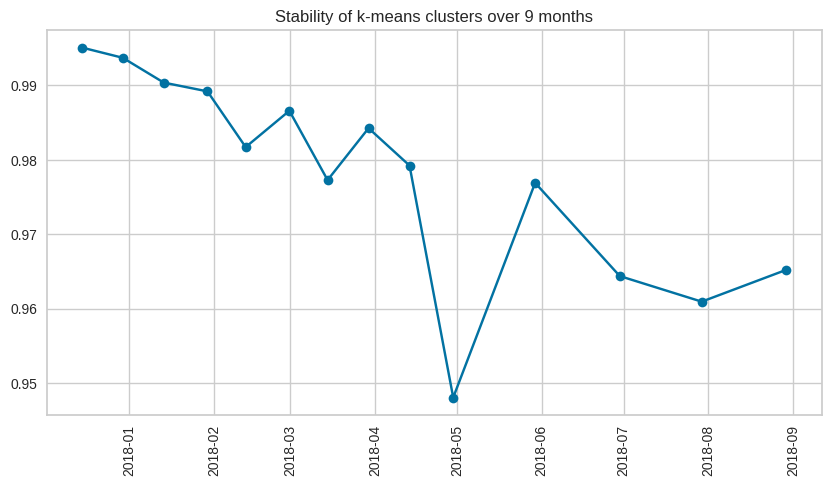

In [30]:
# Stability of clusters visualization
plt.figure(figsize=(10, 5))
plt.plot(df_ari_results["Date"], df_ari_results["ARI"], "o-")
plt.title("Stability of k-means clusters over 9 months")
plt.xticks(rotation=90)

plt.show()

---
---
<a id='test_stability_quantiMM4'></a>

## <font color = '#0085dd'>Stability Test on 4 k-means clusters over quantitative data (MinMax Scaler)</font>

In [31]:
# Preparing data
df_custom_quanti = df_stab_analysis.copy()

In [32]:
# dataframe for saving ARI scores
df_qt_ari_results = pd.DataFrame({})

# Clustering hyperparameters
N = 4
n_ind = 20
init_meth = "random"

In [33]:
# Creation of the quantitative dataframe on the reference date
df_quanti_reference = pd.DataFrame()
df_qt_ref = df_custom_quanti[df_custom_quanti["order_purchase_timestamp"]
                             < reference_date]

df_quanti_reference = create_quantitative_dataset(df_qt_ref, reference_date)

/tmp/ipykernel_35872/3438571233.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["product_volume_L"] =\
/tmp/ipykernel_35872/3438571233.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["review_score_avg"] = dataframe["review_score"]
/tmp/ipykernel_35872/3438571233.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [34]:
# Standardisation
# -------------------------------
scaler_MM = MinMaxScaler(feature_range=(0, 1))

# Reference period Data processing
X_qtref = df_quanti_reference.values
features_qtreference = df_quanti_reference.columns

X_qtref_MM = scaler_MM.fit_transform(X_qtref)
# Dataframe
df_scaled_qtref = pd.DataFrame(X_qtref_MM,
                               index=df_quanti_reference.index,
                               columns=features_qtreference)

# Model instantiation
kmeans_qtMM = cluster.KMeans(n_clusters=N, n_init=n_ind,
                             init=init_meth, random_state=seed)
kmeans_qtMM.fit_predict(X_qtref_MM)
kmeans_labels_qtref = kmeans_qtMM.labels_
df_scaled_qtref["Cluster"] = kmeans_qtMM.labels_

df_quanti_reference = df_quanti_reference.reset_index()

In [35]:
df_qt_ari_results, df_qthist_15days =\
            quantiMM_cls_stability(df_custom_quanti,
                                   df_qt_ari_results,
                                   date_hist_15days,
                                   "15_days_Nov_midDecember", N)

In [36]:
df_qt_ari_results, df_qthist_1month =\
            quantiMM_cls_stability(df_custom_quanti,
                                   df_qt_ari_results,
                                   date_hist_1month,
                                   "1_month_Nov_December", N)

In [37]:
df_qt_ari_results, df_qthist_45days =\
            quantiMM_cls_stability(df_custom_quanti,
                                   df_qt_ari_results,
                                   date_hist_45days,
                                   "45_days_Nov_midJanuary", N)

In [38]:
df_qt_ari_results, df_qthist_2month =\
            quantiMM_cls_stability(df_custom_quanti,
                                   df_qt_ari_results,
                                   date_hist_2month,
                                   "2_month_Nov_January", N)

In [39]:
df_qt_ari_results, df_qthist_75days =\
            quantiMM_cls_stability(df_custom_quanti,
                                   df_qt_ari_results,
                                   date_hist_75days,
                                   "75_days_Nov_midFebruary", N)

In [40]:
df_qt_ari_results, df_qthist_3month =\
            quantiMM_cls_stability(df_custom_quanti,
                                   df_qt_ari_results,
                                   date_hist_3month,
                                   "3_month_Nov_February", N)

In [41]:
df_qt_ari_results, df_qthist_105days = quantiMM_cls_stability(df_custom_quanti,
                                           df_qt_ari_results,
                                           date_hist_105days,
                                           "105_days_Nov_midMarch", N)

In [42]:
df_qt_ari_results, df_qthist_4month =\
            quantiMM_cls_stability(df_custom_quanti,
                                   df_qt_ari_results,
                                   date_hist_4month,
                                   "4_month_Nov_March", N)

In [43]:
df_qt_ari_results, df_qthist_135days =\
            quantiMM_cls_stability(df_custom_quanti,
                                   df_qt_ari_results,
                                   date_hist_135days,
                                   "135_days_Nov_midApril", N)

In [44]:
df_qt_ari_results, df_qthist_5month =\
            quantiMM_cls_stability(df_custom_quanti,
                                   df_qt_ari_results,
                                   date_hist_5month,
                                   "5_month_Nov_April", N)

In [45]:
df_qt_ari_results, df_qthist_6month =\
            quantiMM_cls_stability(df_custom_quanti,
                                   df_qt_ari_results,
                                   date_hist_6month,
                                   "6_month_Nov_May", N)

In [46]:
df_qt_ari_results, df_qthist_7month =\
            quantiMM_cls_stability(df_custom_quanti,
                                   df_qt_ari_results,
                                   date_hist_7month,
                                   "7_month_Nov_June", N)

In [47]:
df_qt_ari_results, df_qthist_8month =\
            quantiMM_cls_stability(df_custom_quanti,
                                   df_qt_ari_results,
                                   date_hist_8month,
                                   "8_month_Nov_July", N)

In [48]:
df_qt_ari_results, df_qthist_9month =\
            quantiMM_cls_stability(df_custom_quanti,
                                   df_qt_ari_results,
                                   date_hist_9month,
                                   "9_month_Nov_August", N)

In [49]:
df_qt_ari_results.style.hide(axis="index")

Period,Date,ARI
15_days_Nov_midDecember,2017-12-14 15:00:37+00:00,0.990609
1_month_Nov_December,2017-12-29 15:00:37+00:00,0.976951
45_days_Nov_midJanuary,2018-01-13 15:00:37+00:00,0.955894
2_month_Nov_January,2018-01-29 15:00:37+00:00,0.947928
75_days_Nov_midFebruary,2018-02-12 15:00:37+00:00,0.933136
3_month_Nov_February,2018-02-28 15:00:37+00:00,0.924866
105_days_Nov_midMarch,2018-03-14 15:00:37+00:00,0.910285
4_month_Nov_March,2018-03-29 15:00:37+00:00,0.906143
135_days_Nov_midApril,2018-04-13 15:00:37+00:00,0.899451
5_month_Nov_April,2018-04-29 15:00:37+00:00,0.335329


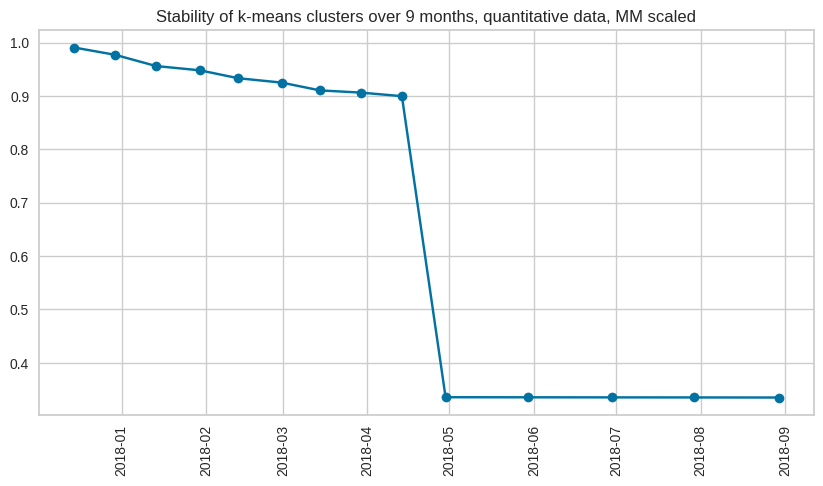

In [50]:
# Stability of clusters visualization
plt.figure(figsize=(10, 5))
plt.plot(df_qt_ari_results["Date"], df_qt_ari_results["ARI"], "o-")
plt.title("Stability of k-means clusters over 9 months, quantitative data, MM scaled")
plt.xticks(rotation=90)

plt.show()

<a id='features_changes'></a>

### <span style='background:#0075bc'><span style='color:white'>Analysis of features changes close to the ARI drop</span></span>


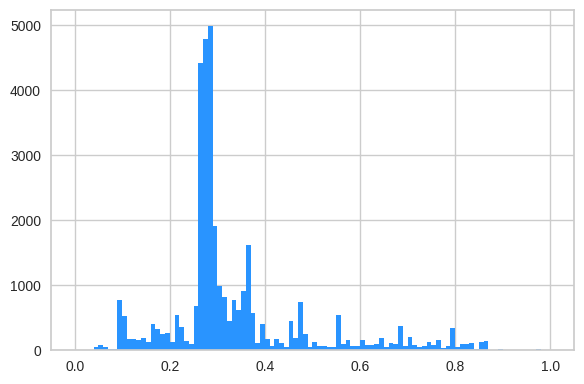

In [51]:
# Average review score reference date
df_scaled_qtref.customer_geoloc_avg_lat.hist(bins=100,
                                             figsize=(6, 4),
                                             color="#2994ff")
plt.tight_layout()
plt.show()

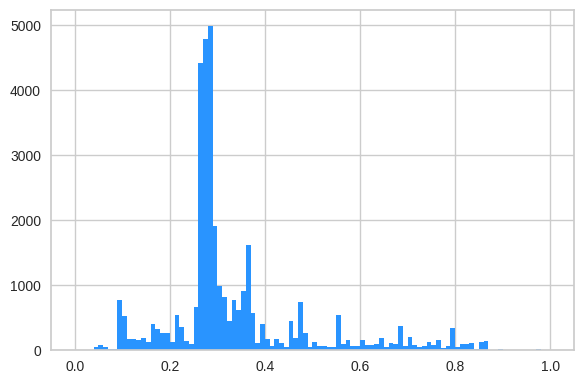

In [52]:
# Average review score reference date
df_qthist_135days.customer_geoloc_avg_lat.hist(bins=100,
                                               figsize=(6, 4),
                                               color="#2994ff")
plt.tight_layout()
plt.show()

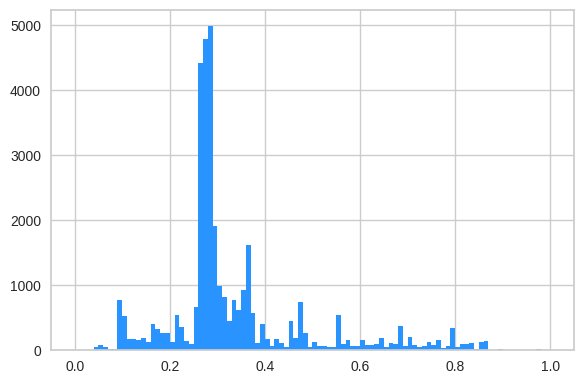

In [53]:
# Average review score reference date
df_qthist_5month.customer_geoloc_avg_lat.hist(bins=100,
                                              figsize=(6, 4),
                                              color="#2994ff")
plt.tight_layout()
plt.show()

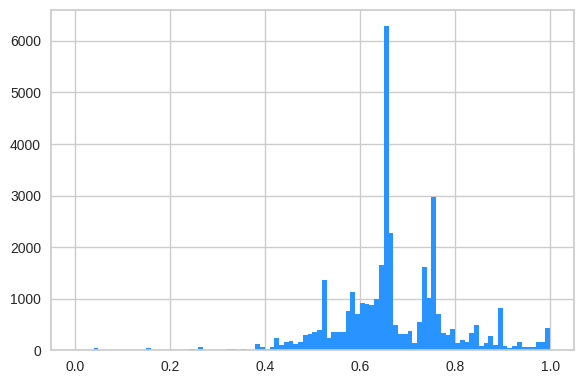

In [54]:
# Average review score reference date
df_scaled_qtref.customer_geoloc_avg_lng.hist(bins=100,
                                             figsize=(6, 4),
                                             color="#2994ff")
plt.tight_layout()
plt.show()

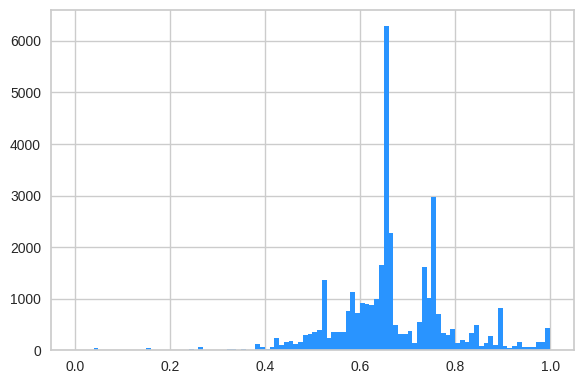

In [55]:
# Average review score reference date
df_qthist_135days.customer_geoloc_avg_lng.hist(bins=100,
                                               figsize=(6, 4),
                                               color="#2994ff")
plt.tight_layout()
plt.show()

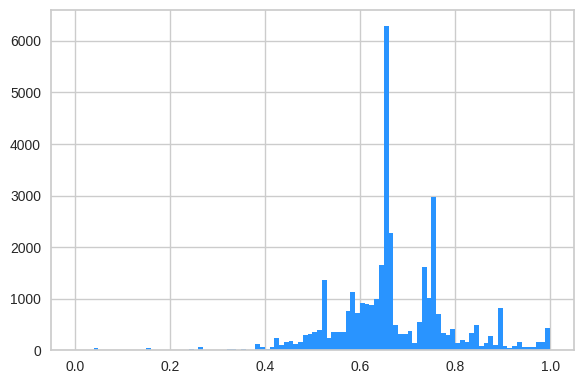

In [56]:
# Average review score reference date
df_qthist_5month.customer_geoloc_avg_lng.hist(bins=100,
                                              figsize=(6, 4),
                                              color="#2994ff")
plt.tight_layout()
plt.show()

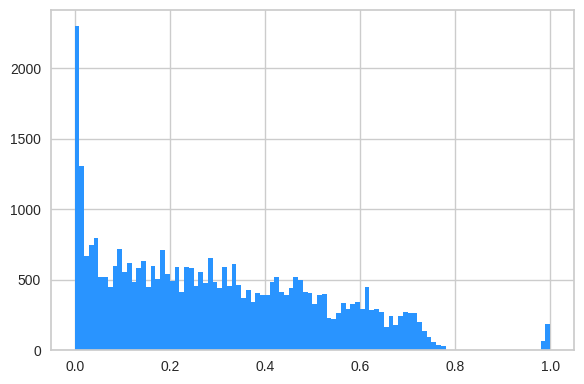

In [57]:
# Average review score reference date
df_scaled_qtref.Recency.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

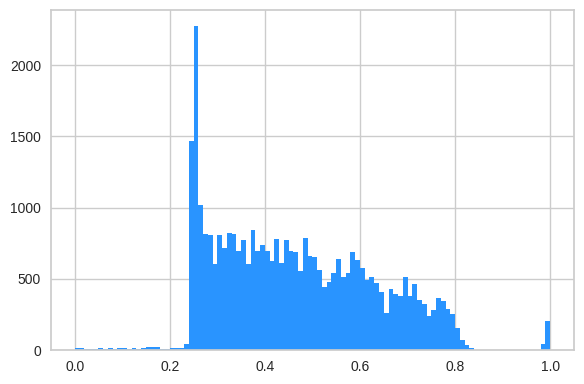

In [58]:
# Average review score reference date
df_qthist_135days.Recency.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

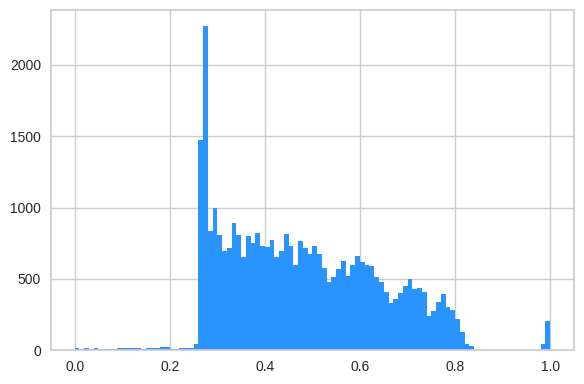

In [59]:
# Average review score reference date
df_qthist_5month.Recency.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

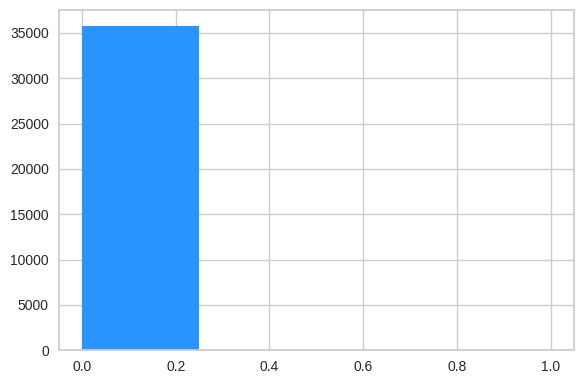

In [60]:
# Average review score reference date
df_scaled_qtref.Frequency.hist(bins=4,
                                          figsize=(6, 4),
                                          color="#2994ff")
plt.tight_layout()
plt.show()

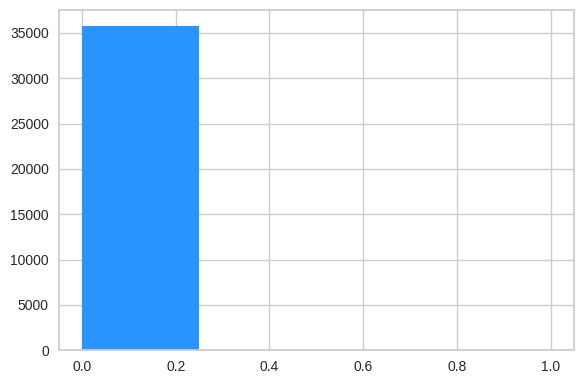

In [61]:
# Average review score reference date
df_qthist_135days.Frequency.hist(bins=4,
                                            figsize=(6, 4),
                                            color="#2994ff")
plt.tight_layout()
plt.show()

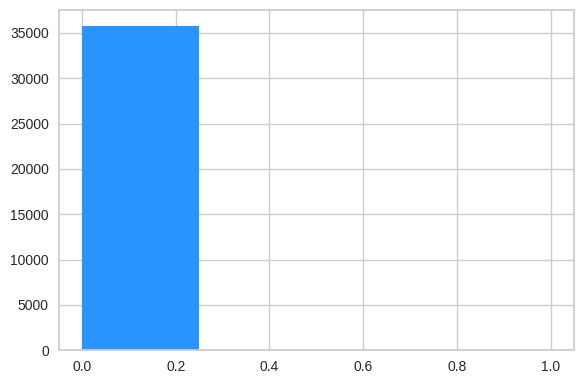

In [62]:
# Average review score reference date
df_qthist_5month.Frequency.hist(bins=4,
                                           figsize=(6, 4),
                                           color="#2994ff")
plt.tight_layout()
plt.show()

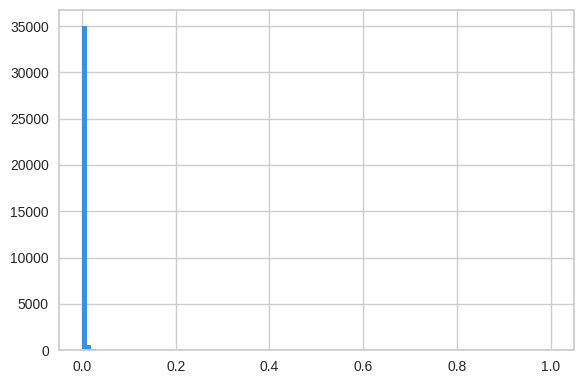

In [63]:
# Average review score reference date
df_scaled_qtref.Monetary.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

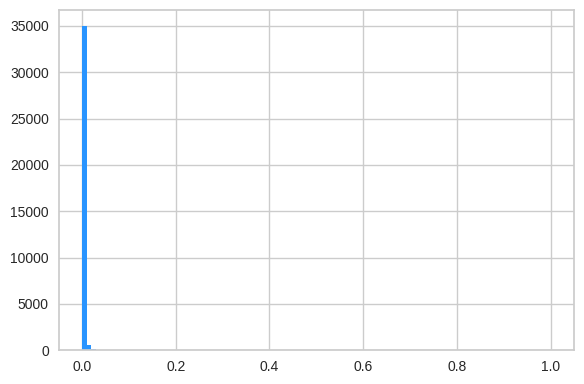

In [64]:
# Average review score reference date
df_qthist_135days.Monetary.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

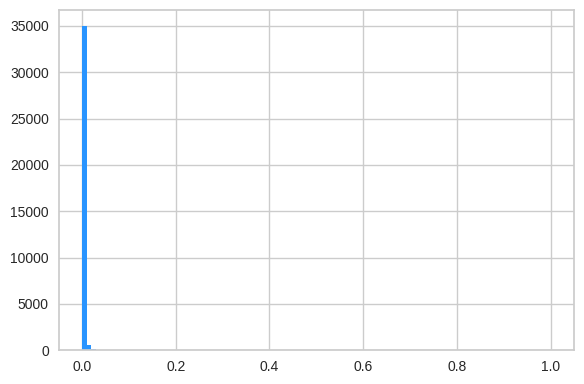

In [65]:
# Average review score reference date
df_qthist_5month.Monetary.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

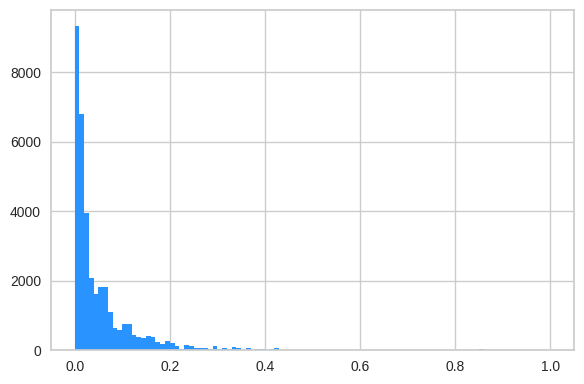

In [66]:
# Average review score reference date
df_scaled_qtref.average_vol_product_L.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

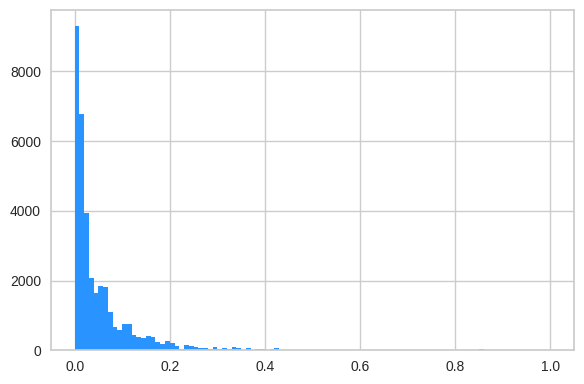

In [67]:
# Average review score reference date
df_qthist_135days.average_vol_product_L.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

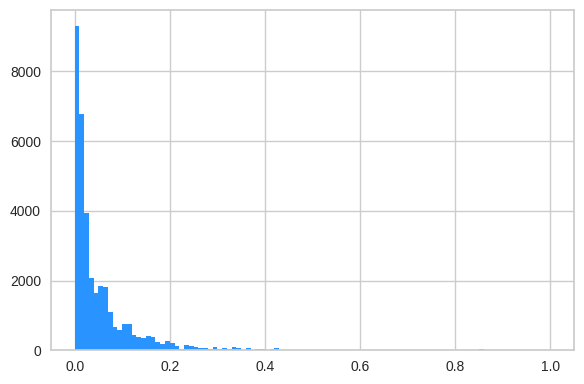

In [68]:
# Average review score reference date
df_qthist_5month.average_vol_product_L.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

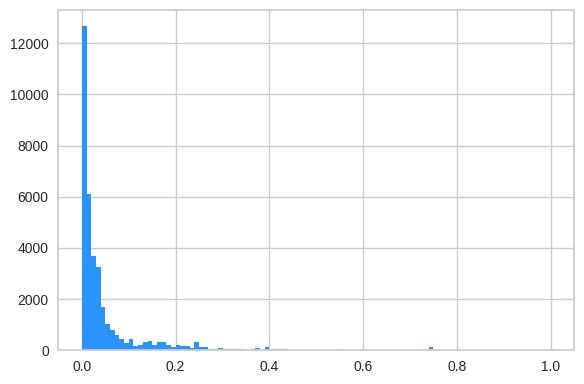

In [69]:
# Average review score reference date
df_scaled_qtref.average_weight_product_g.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

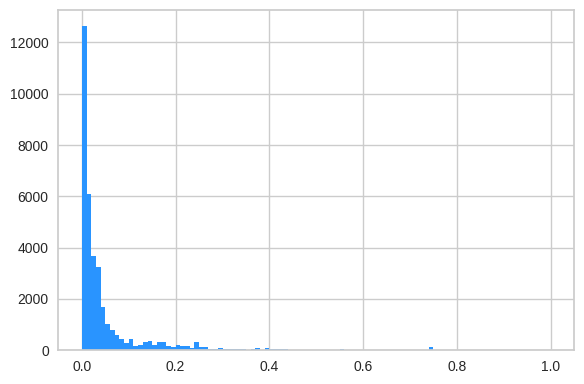

In [70]:
# Average review score reference date
df_qthist_135days.average_weight_product_g.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

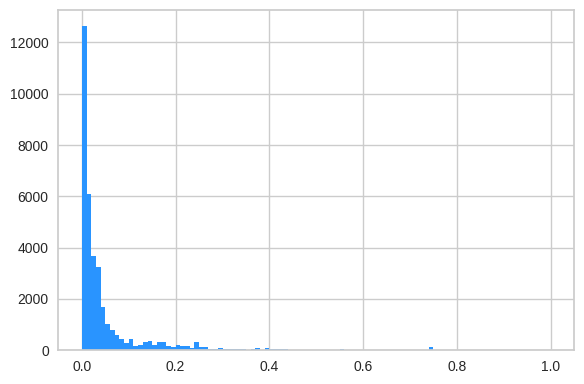

In [71]:
# Average review score reference date
df_qthist_5month.average_weight_product_g.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

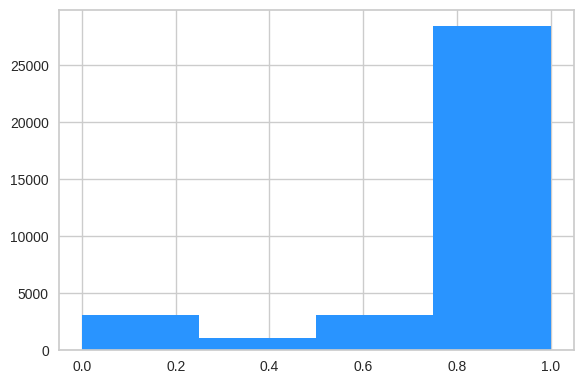

In [72]:
# Average review score reference date
df_scaled_qtref.average_review_score.hist(bins=4,
                                          figsize=(6, 4),
                                          color="#2994ff")
plt.tight_layout()
plt.show()

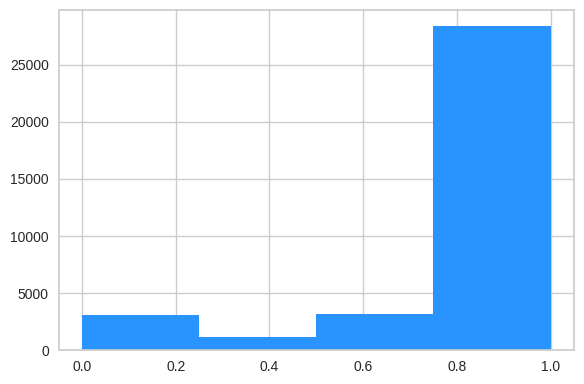

In [73]:
# Average review score reference date
df_qthist_135days.average_review_score.hist(bins=4,
                                            figsize=(6, 4),
                                            color="#2994ff")
plt.tight_layout()
plt.show()

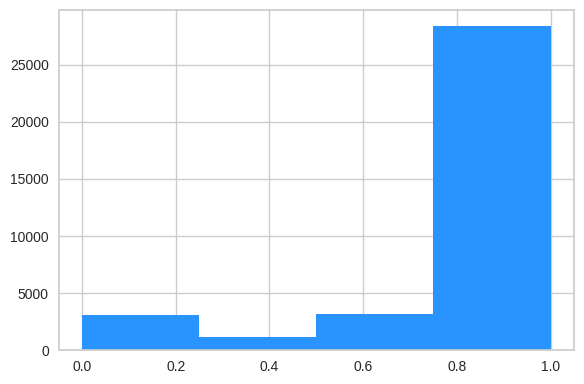

In [74]:
# Average review score reference date
df_qthist_5month.average_review_score.hist(bins=4,
                                           figsize=(6, 4),
                                           color="#2994ff")
plt.tight_layout()
plt.show()

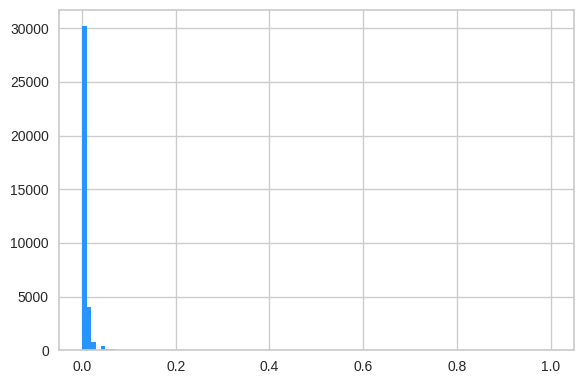

In [75]:
# Average review score reference date
df_scaled_qtref.total_num_products.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

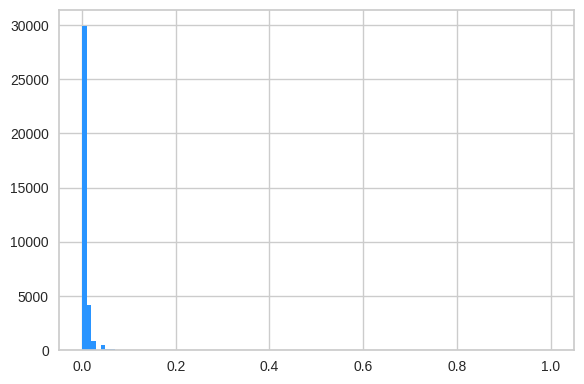

In [76]:
# Average review score reference date
df_qthist_135days.total_num_products.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

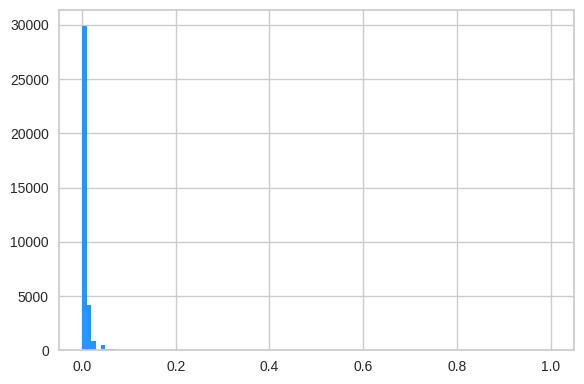

In [77]:
# Average review score reference date
df_qthist_5month.total_num_products.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

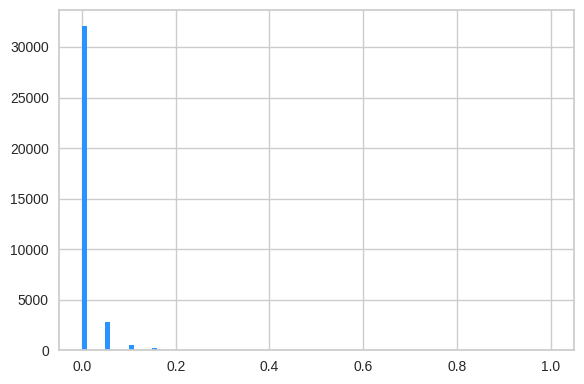

In [78]:
# Average review score reference date
df_scaled_qtref.max_items.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

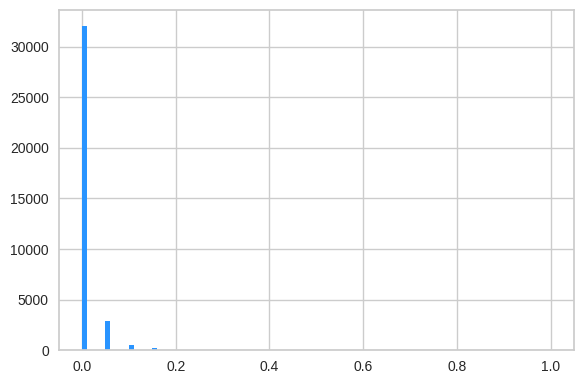

In [79]:
# Average review score reference date
df_qthist_135days.max_items.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

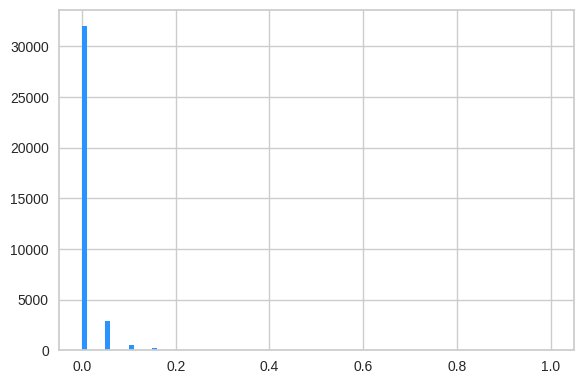

In [80]:
# Average review score reference date
df_qthist_5month.max_items.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

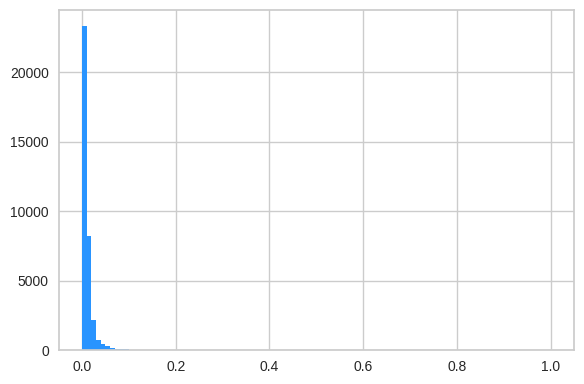

In [81]:
# Average review score reference date
df_scaled_qtref.max_order_value.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

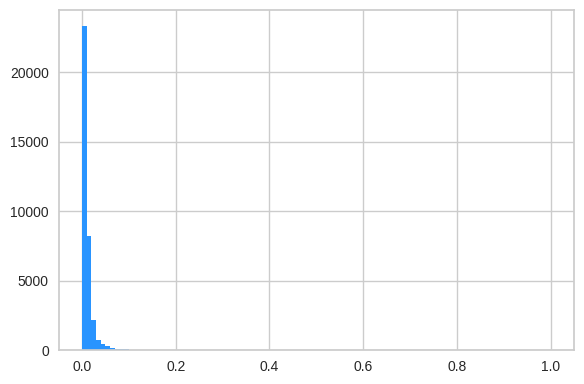

In [82]:
# Average review score reference date
df_qthist_135days.max_order_value.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

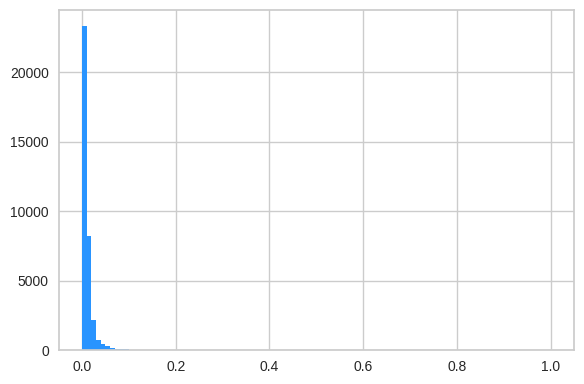

In [83]:
# Average review score reference date
df_qthist_5month.max_order_value.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

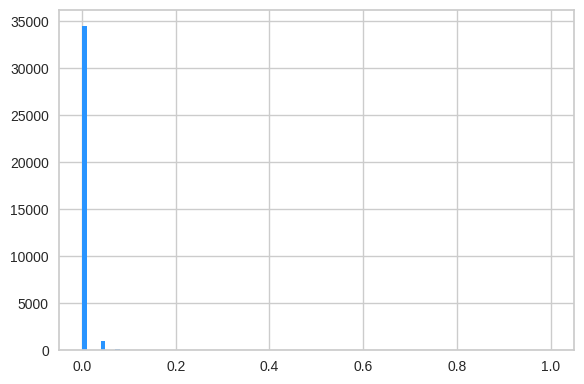

In [84]:
# Average review score reference date
df_scaled_qtref.max_sequential_payment.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

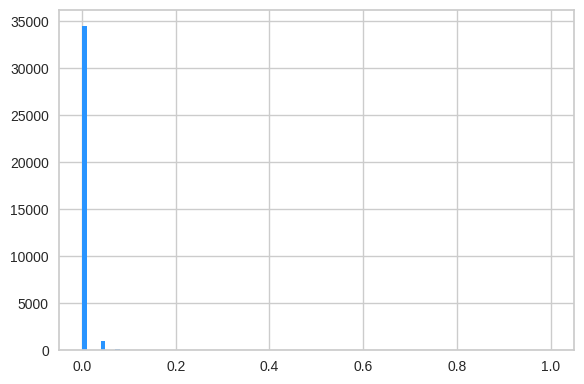

In [85]:
# Average review score reference date
df_qthist_135days.max_sequential_payment.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

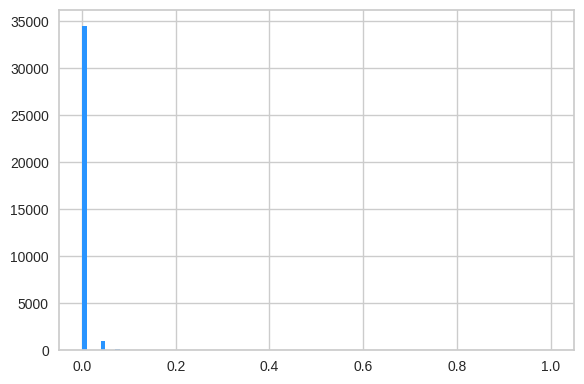

In [86]:
# Average review score reference date
df_qthist_5month.max_sequential_payment.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

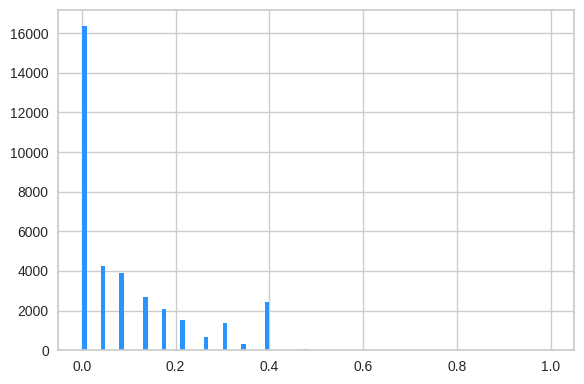

In [87]:
# Average review score reference date
df_scaled_qtref.max_payment_installments.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

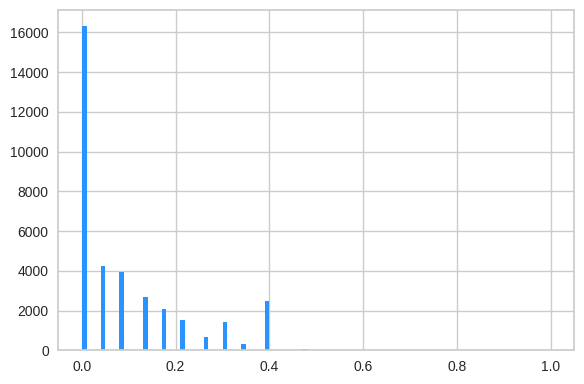

In [88]:
# Average review score reference date
df_qthist_135days.max_payment_installments.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

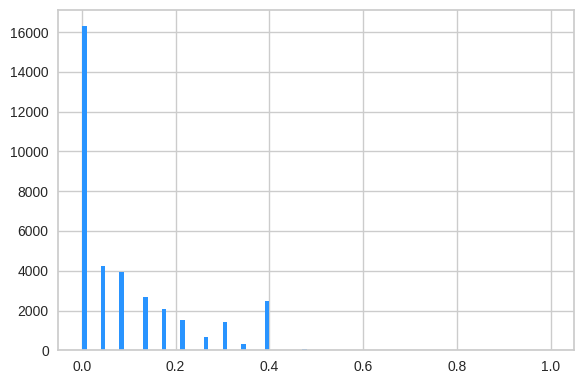

In [89]:
# Average review score reference date
df_qthist_5month.max_payment_installments.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

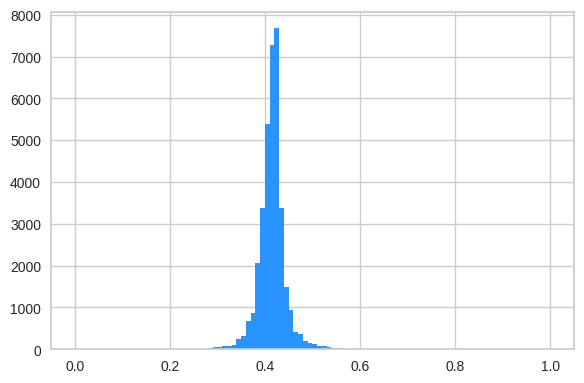

In [90]:
# Average review score reference date
df_scaled_qtref.average_delivery_deviation.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

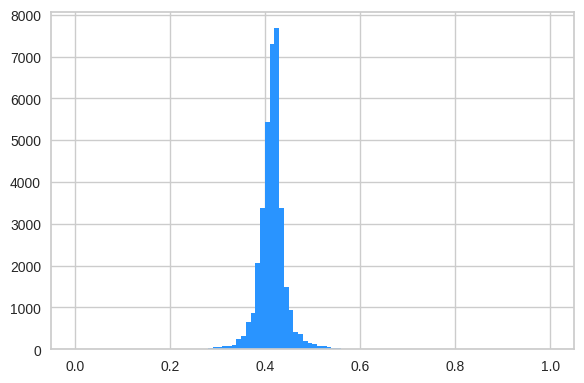

In [91]:
# Average review score reference date
df_qthist_135days.average_delivery_deviation.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

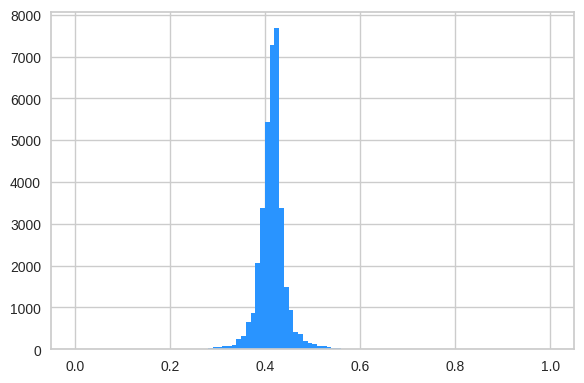

In [92]:
# Average review score reference date
df_qthist_5month.average_delivery_deviation.hist(bins=100, figsize=(6, 4), color="#2994ff")
plt.tight_layout()
plt.show()

<a id="visualize_segment_evolution"></a>

---
---

# <font color = '#26467a'>**Visualization of customer segment evolution** </font>
    

* Sankey diagrams are a type of flow diagram in which the width of the arrows is proportional to the flow. It allows visualization of the distribution between an initial plot and several subsequent smaller plots.

* Sankey diagrams are very useful for visually observing the evolution of customer segments.    

---
---
<a id='custom_segments_6months'></a>

## <font color = '#0085dd'>RFM segmentation over 6 months</font>

In [93]:
# Definition of reference date
# ------------------------------

sankey_reference_date = last_purchase - pd.DateOffset(months=9)
print(f"Reference date whole period : {sankey_reference_date}")

sankey_reference_date

Reference date whole period : 2017-11-29 15:00:37+00:00


Timestamp('2017-11-29 15:00:37+0000', tz='UTC')

In [94]:
# Reference date
# reference_date

# Segmentation on the reference date
df_rfm_reference = rfm_reference_date(df_stab_analysis,
                                      "order_purchase_timestamp",
                                      "order_id",
                                      "payment_value",
                                      "2017_endNovember")

In [95]:
# Date historical period + 15 days
date_hist_15days = sankey_reference_date + pd.DateOffset(days=15)
# Date historical period + 30 days (1 month)
date_hist_30days = sankey_reference_date + pd.DateOffset(days=30)
# Date historical period + 60 days (2 month)
date_hist_60days = sankey_reference_date + pd.DateOffset(days=60)
# Date historical period + 90 days (3 month)
date_hist_90days = sankey_reference_date + pd.DateOffset(days=90)
# Date historical period + 150 days (5 months)
date_hist_150days = sankey_reference_date + pd.DateOffset(days=150)
# Date historical period + 180 days (6 months)
date_hist_180days = sankey_reference_date + pd.DateOffset(days=180)
# Date historical period + 270 days (9 months)
date_hist_270days = sankey_reference_date + pd.DateOffset(days=270)

In [96]:
# Dataframe for saving the ARI scores
df_results_rfm = pd.DataFrame({})

In [97]:
# RFM segmentation 15 days after the reference date
df_results_rfm, df_rfm_15days = rfm_segment_period(df_stab_analysis,
                                                   df_rfm_reference,
                                                   df_results_rfm,
                                                   "order_purchase_timestamp",
                                                   "order_id",
                                                   "payment_value",
                                                   date_hist_15days,
                                                   "15d_Nov_midDecember")

Reference date : 2017-11-29 15:00:37+00:00
Period : Min : 2017-11-29 15:00:37+00:00, Max : 2017-12-14 14:53:42+00:00
(35742, 18)
(35742, 18)
ARI score : 0.9853302478381631


In [98]:
# RFM segmentation 1 month after the reference date
df_results_rfm, df_rfm_1month = rfm_segment_period(df_stab_analysis,
                                                   df_rfm_reference,
                                                   df_results_rfm,
                                                   "order_purchase_timestamp",
                                                   "order_id",
                                                   "payment_value",
                                                   date_hist_30days,
                                                   "1_month_Nov_December")

Reference date : 2017-11-29 15:00:37+00:00
Period : Min : 2017-11-29 15:00:37+00:00, Max : 2017-12-29 14:58:22+00:00
(35742, 18)
(35742, 18)
ARI score : 0.9815524390499767


In [99]:
# RFM segmentation 2 month after the reference date
df_results_rfm, df_rfm_2month = rfm_segment_period(df_stab_analysis,
                                                   df_rfm_reference,
                                                   df_results_rfm,
                                                   "order_purchase_timestamp",
                                                   "order_id",
                                                   "payment_value",
                                                   date_hist_60days,
                                                   "2_month_Nov_January")

Reference date : 2017-11-29 15:00:37+00:00
Period : Min : 2017-11-29 15:00:37+00:00, Max : 2018-01-28 14:59:52+00:00
(35742, 18)
(35742, 18)
ARI score : 0.960526018620759


In [100]:
# RFM segmentation 3 months after the reference date
df_results_rfm, df_rfm_3month = rfm_segment_period(df_stab_analysis,
                                                   df_rfm_reference,
                                                   df_results_rfm,
                                                   "order_purchase_timestamp",
                                                   "order_id",
                                                   "payment_value",
                                                   date_hist_90days,
                                                   "3_month_Nov_February")

Reference date : 2017-11-29 15:00:37+00:00
Period : Min : 2017-11-29 15:00:37+00:00, Max : 2018-02-27 14:59:25+00:00
(35742, 18)
(35742, 18)
ARI score : 0.9548674721863261


In [101]:
# RFM segmentation 5 months after the reference date
df_results_rfm, df_rfm_5month = rfm_segment_period(df_stab_analysis,
                                                   df_rfm_reference,
                                                   df_results_rfm,
                                                   "order_purchase_timestamp",
                                                   "order_id",
                                                   "payment_value",
                                                   date_hist_150days,
                                                   "5_month_Nov_April")

Reference date : 2017-11-29 15:00:37+00:00
Period : Min : 2017-11-29 15:00:37+00:00, Max : 2018-04-28 15:00:33+00:00
(35742, 18)
(35742, 18)
ARI score : 0.9238302924695287


In [102]:
# RFM segmentation 6 months after the reference date
df_results_rfm, df_rfm_6month = rfm_segment_period(df_stab_analysis,
                                                   df_rfm_reference,
                                                   df_results_rfm,
                                                   "order_purchase_timestamp",
                                                   "order_id",
                                                   "payment_value",
                                                   date_hist_180days,
                                                   "6_month_Nov_May")

Reference date : 2017-11-29 15:00:37+00:00
Period : Min : 2017-11-29 15:00:37+00:00, Max : 2018-05-28 14:52:34+00:00
(35742, 18)
(35742, 18)
ARI score : 0.909313262836421


In [103]:
# RFM segmentation 9 months after the reference date
df_results_rfm, df_rfm_9month = rfm_segment_period(df_stab_analysis,
                                                   df_rfm_reference,
                                                   df_results_rfm,
                                                   "order_purchase_timestamp",
                                                   "order_id",
                                                   "payment_value",
                                                   date_hist_270days,
                                                   "9_month_Nov_Aug")

Reference date : 2017-11-29 15:00:37+00:00
Period : Min : 2017-11-29 15:00:37+00:00, Max : 2018-08-26 14:39:46+00:00
(35742, 18)
(35742, 18)
ARI score : 0.89350558484329


In [104]:
# ARI scores from the different historical periods
df_results_rfm.style.hide(axis="index")

Period,ARI
15d_Nov_midDecember,0.985330
1_month_Nov_December,0.981552
2_month_Nov_January,0.960526
3_month_Nov_February,0.954867
5_month_Nov_April,0.923830
6_month_Nov_May,0.909313
9_month_Nov_Aug,0.893506


---
---
<a id='df_creation_sankey_diagr'></a>

## <font color = '#0085dd'>Creating dataframes for Sankey diagrams</font>

In [105]:
df_sankey = pd.DataFrame()

In [106]:
# Creation of the df for Sankey diagrams
# ---------------------------------------
# Merge reference segments
df_rfm_reference.rename(columns={"RFM_Segm_Client": "RFM_Segm_reference"},
                        inplace=True)
df_sankey = df_stab_analysis.merge(df_rfm_reference[["customer_unique_id",
                                                     "RFM_Segm_reference"]],
                                   on="customer_unique_id", how="left")

# Merge full period and 15 days history dataset
df_rfm_15days.rename(columns={"RFM_Segm_Client": "RFM_Segm_15days"},
                     inplace=True)
df_sankey = pd.merge(df_sankey[["customer_unique_id", "RFM_Segm_reference"]],
                     df_rfm_15days[["customer_unique_id",
                                    "RFM_Segm_15days"]],
                     on="customer_unique_id", how="left")

# Merge full period and 15 days history dataset
# and 1 month history dataset
df_rfm_1month.rename(columns={"RFM_Segm_Client": "RFM_Segm_1month"},
                     inplace=True)
df_sankey = pd.merge(df_sankey, df_rfm_1month[["customer_unique_id",
                                               "RFM_Segm_1month"]],
                     on="customer_unique_id", how="left")

# Merge full period and 15 days history dataset
# 1 month, 2 and 3 months history dataset
df_rfm_2month.rename(columns={"RFM_Segm_Client": "RFM_Segm_2months"},
                     inplace=True)
df_sankey = pd.merge(df_sankey, df_rfm_2month[["customer_unique_id",
                                               "RFM_Segm_2months"]],
                     on="customer_unique_id", how="left")

# Merge full period and 15 days history dataset
# 1 month and 3 months history dataset
df_rfm_3month.rename(columns={"RFM_Segm_Client": "RFM_Segm_3months"},
                     inplace=True)
df_sankey = pd.merge(df_sankey, df_rfm_3month[["customer_unique_id",
                                               "RFM_Segm_3months"]],
                     on="customer_unique_id", how="left")

# Merge full period and 15 days history dataset
# 1 month, 3 months and 5 months history dataset
df_rfm_5month.rename(columns={"RFM_Segm_Client": "RFM_Segm_5months"},
                     inplace=True)
df_sankey = pd.merge(df_sankey, df_rfm_5month[["customer_unique_id",
                                               "RFM_Segm_5months"]],
                     on="customer_unique_id", how="left")

# Merge full period and 15 days history dataset
# 1 month, 3, 5 months and 6 months history dataset
df_rfm_6month.rename(columns={"RFM_Segm_Client": "RFM_Segm_6months"},
                     inplace=True)
df_sankey = pd.merge(df_sankey, df_rfm_6month[["customer_unique_id",
                                               "RFM_Segm_6months"]],
                     on="customer_unique_id", how="left")

# Merge full period and 15 days history dataset
# 1 month, 3, 5, 6 months and 9 months history dataset
df_rfm_9month.rename(columns={"RFM_Segm_Client": "RFM_Segm_9months"},
                     inplace=True)
df_sankey = pd.merge(df_sankey, df_rfm_9month[["customer_unique_id",
                                               "RFM_Segm_9months"]],
                     on="customer_unique_id", how="left")
df_sankey.head()

,customer_unique_id,RFM_Segm_reference,RFM_Segm_15days,RFM_Segm_1month,RFM_Segm_2months,RFM_Segm_3months,RFM_Segm_5months,RFM_Segm_6months,RFM_Segm_9months
0,861eff4711a542e4b93843c6dd7febb0,Sleeping customer,Sleeping customer,Sleeping customer,Sleeping customer,Sleeping customer,Sleeping customer,Sleeping customer,Sleeping customer
1,290c77bc529b7ac935b93aa66c333dc3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,060e732b5b29e8181a18229c7b0b2b5e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,259dac757896d24d7702b9acbbff3f3c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,345ecd01c38d18a9036ed96c73b8d066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
# Comparison Dataframe reference period / historical period
# --------------------------------------------------------------------
df_sankey_15days = \
    df_sankey.groupby(by=["RFM_Segm_15days", "RFM_Segm_reference"]) \
    .agg({"RFM_Segm_reference" : "count"})
df_sankey_15days.rename(columns={"RFM_Segm_reference" : "15days_value"},
                        inplace=True)
df_sankey_15days = df_sankey_15days.reset_index()

In [108]:
# Comparison Dataframe reference period / historical period
# --------------------------------------------------------------------
df_sankey_1month = \
    df_sankey.groupby(by=["RFM_Segm_1month", "RFM_Segm_reference"]) \
    .agg({"RFM_Segm_reference" : "count"})
df_sankey_1month.rename(columns={"RFM_Segm_reference" : "1month_value"},
                        inplace=True)
df_sankey_1month = df_sankey_1month.reset_index()

In [109]:
# Comparison Dataframe reference period / historical period
# --------------------------------------------------------------------
df_sankey_2month = \
    df_sankey.groupby(by=["RFM_Segm_2months", "RFM_Segm_reference"]) \
    .agg({"RFM_Segm_reference" : "count"})
df_sankey_2month.rename(columns={"RFM_Segm_reference" : "2month_value"},
                        inplace=True)
df_sankey_2month = df_sankey_2month.reset_index()

In [110]:
# Comparison Dataframe reference period / historical period
# --------------------------------------------------------------------
df_sankey_3month = \
    df_sankey.groupby(by=["RFM_Segm_3months", "RFM_Segm_reference"]) \
    .agg({"RFM_Segm_reference" : "count"})
df_sankey_3month.rename(columns={"RFM_Segm_reference" : "3months_value"},
                        inplace=True)
df_sankey_3month = df_sankey_3month.reset_index()

In [111]:
# Comparison Dataframe reference period / historical period
# --------------------------------------------------------------------
df_sankey_5month = \
    df_sankey.groupby(by=["RFM_Segm_5months", "RFM_Segm_reference"]) \
    .agg({"RFM_Segm_reference" : "count"})
df_sankey_5month.rename(columns={"RFM_Segm_reference" : "5months_value"},
                        inplace=True)
df_sankey_5month = df_sankey_5month.reset_index()

In [112]:
# Comparison Dataframe reference period / historical period
# --------------------------------------------------------------------
df_sankey_6month = \
    df_sankey.groupby(by=["RFM_Segm_6months", "RFM_Segm_reference"]) \
    .agg({"RFM_Segm_reference" : "count"})
df_sankey_6month.rename(columns={"RFM_Segm_reference" : "6months_value"},
                        inplace=True)
df_sankey_6month = df_sankey_6month.reset_index()

In [113]:
# Comparison Dataframe reference period / historical period
# --------------------------------------------------------------------
df_sankey_9month = \
    df_sankey.groupby(by=["RFM_Segm_9months", "RFM_Segm_reference"]) \
    .agg({"RFM_Segm_reference" : "count"})
df_sankey_9month.rename(columns={"RFM_Segm_reference" : "9months_value"},
                        inplace=True)
df_sankey_9month = df_sankey_9month.reset_index()

In [114]:
%pycodestyle_on

In [166]:
# Preparing the source of the Sankey diagram
# --------------------------------------------------------------------
# Add source feature : transform string in int
# 15 days stability comparison
df_sankey_15days["Source"] = ["0" if row == "Lost customer"
                              else "1" if row == "Sleeping customer"
                              else "2" if row == "Endangered customer"
                              else "3" if row == "New customer"
                              else "4" if row == "Need attention"
                              else "5" if row == "Loyal customer to protect"
                              else "6" if row == "Champions"
                              else "7"
                              for row in df_sankey_15days["RFM_Segm_15days"]]

# 1 month stability comparison
df_sankey_1month["Source"] = ["0" if row == "Lost customer"
                              else "1" if row == "Sleeping customer"
                              else "2" if row == "Endangered customer"
                              else "3" if row == "New customer"
                              else "4" if row == "Need attention"
                              else "5" if row == "Loyal customer to protect"
                              else "6" if row == "Champions"
                              else "7"
                              for row in df_sankey_1month["RFM_Segm_1month"]]

# 2 month stability comparison
df_sankey_2month["Source"] = ["0" if row == "Lost customer"
                              else "1" if row == "Sleeping customer"
                              else "2" if row == "Endangered customer"
                              else "3" if row == "New customer"
                              else "4" if row == "Need attention"
                              else "5" if row == "Loyal customer to protect"
                              else "6" if row == "Champions"
                              else "7"
                              for row in df_sankey_2month["RFM_Segm_2months"]]

# 3 months stability comparison
df_sankey_3month["Source"] = ["0" if row == "Lost customer"
                              else "1" if row == "Sleeping customer"
                              else "2" if row == "Endangered customer"
                              else "3" if row == "New customer"
                              else "4" if row == "Need attention"
                              else "5" if row == "Loyal customer to protect"
                              else "6" if row == "Champions"
                              else "7"
                              for row in df_sankey_3month["RFM_Segm_3months"]]

# 5 months stability comparison
df_sankey_5month["Source"] = ["0" if row == "Lost customer"
                              else "1" if row == "Sleeping customer"
                              else "2" if row == "Endangered customer"
                              else "3" if row == "New customer"
                              else "4" if row == "Need attention"
                              else "5" if row == "Loyal customer to protect"
                              else "6" if row == "Champions"
                              else "7"
                              for row in df_sankey_5month["RFM_Segm_5months"]]

# 6 months stability comparison
df_sankey_6month["Source"] = ["0" if row == "Lost customer"
                              else "1" if row == "Sleeping customer"
                              else "2" if row == "Endangered customer"
                              else "3" if row == "New customer"
                              else "4" if row == "Need attention"
                              else "5" if row == "Loyal customer to protect"
                              else "6" if row == "Champions"
                              else "7"
                              for row in df_sankey_6month["RFM_Segm_6months"]]

# 9 months stability comparison
df_sankey_9month["Source"] = ["0" if row == "Lost customer"
                              else "1" if row == "Sleeping customer"
                              else "2" if row == "Endangered customer"
                              else "3" if row == "New customer"
                              else "4" if row == "Need attention"
                              else "5" if row == "Loyal customer to protect"
                              else "6" if row == "Champions"
                              else "7"
                              for row in df_sankey_9month["RFM_Segm_9months"]]

In [117]:
# Preparing the target of the Sankey diagram
# --------------------------------------------------------------------
# Add source feature : transform string in int
# 15 days stability comparison
df_sankey_15days["Target"] = ["7" if row == "Lost customer"
                              else "8" if row == "Sleeping customer"
                              else "9" if row == "Endangered customer"
                              else "10" if row == "New customer"
                              else "11" if row == "Need attention"
                              else "12" if row == "Loyal customer to protect"
                              else "13" if row == "Champions"
                              else "14"
                              for row in df_sankey_15days[
                                                  "RFM_Segm_reference"]]

# 1 month stability comparison
df_sankey_1month["Target"] = ["7" if row == "Lost customer"
                              else "8" if row == "Sleeping customer"
                              else "9" if row == "Endangered customer"
                              else "10" if row == "New customer"
                              else "11" if row == "Need attention"
                              else "12" if row == "Loyal customer to protect"
                              else "13" if row == "Champions"
                              else "14"
                              for row in df_sankey_1month[
                                                  "RFM_Segm_reference"]]

# 2 month stability comparison
df_sankey_2month["Target"] = ["7" if row == "Lost customer"
                              else "8" if row == "Sleeping customer"
                              else "9" if row == "Endangered customer"
                              else "10" if row == "New customer"
                              else "11" if row == "Need attention"
                              else "12" if row == "Loyal customer to protect"
                              else "13" if row == "Champions"
                              else "14"
                              for row in df_sankey_2month[
                                                  "RFM_Segm_reference"]]

# 3 months stability comparison
df_sankey_3month["Target"] = ["7" if row == "Lost customer"
                              else "8" if row == "Sleeping customer"
                              else "9" if row == "Endangered customer"
                              else "10" if row == "New customer"
                              else "11" if row == "Need attention"
                              else "12" if row == "Loyal customer to protect"
                              else "13" if row == "Champions"
                              else "14"
                              for row in df_sankey_3month[
                                                  "RFM_Segm_reference"]]

# 5 months stability comparison
df_sankey_5month["Target"] = ["7" if row == "Lost customer"
                              else "8" if row == "Sleeping customer"
                              else "9" if row == "Endangered customer"
                              else "10" if row == "New customer"
                              else "11" if row == "Need attention"
                              else "12" if row == "Loyal customer to protect"
                              else "13" if row == "Champions"
                              else "14"
                              for row in df_sankey_5month[
                                                  "RFM_Segm_reference"]]

# 6 months stability comparison
df_sankey_6month["Target"] = ["7" if row == "Lost customer"
                              else "8" if row == "Sleeping customer"
                              else "9" if row == "Endangered customer"
                              else "10" if row == "New customer"
                              else "11" if row == "Need attention"
                              else "12" if row == "Loyal customer to protect"
                              else "13" if row == "Champions"
                              else "14"
                              for row in df_sankey_6month[
                                                  "RFM_Segm_reference"]]

# 9 months stability comparison
df_sankey_9month["Target"] = ["7" if row == "Lost customer"
                              else "8" if row == "Sleeping customer"
                              else "9" if row == "Endangered customer"
                              else "10" if row == "New customer"
                              else "11" if row == "Need attention"
                              else "12" if row == "Loyal customer to protect"
                              else "13" if row == "Champions"
                              else "14"
                              for row in df_sankey_9month[
                                                  "RFM_Segm_reference"]]

In [118]:
label = ["Lost customer", "Sleeping customer", "Endangered customer",
         "New customer", "Need attention", "Loyal customer to protect",
         "Champions", "Lost customer", "Sleeping customer",
         "Endangered customer", "New customer", "Need attention",
         "Loyal customer to protect", "Champions"]

---
---
<a id='15days_visu'></a>

## <font color = '#0085dd'>Visualization Segments stability 15 days</font>

In [119]:
source_15days = df_sankey_15days["Source"].to_list()
target_15days = df_sankey_15days["Target"].to_list()
value_15days = df_sankey_15days["15days_value"].to_list()

In [148]:
color_link_15d = ['#007fba', '#007fba',
                  '#0098c4', '#0098c4',
                  '#ab7ef5', '#ab7ef5', '#ab7ef5',
                  '#00c2a1', '#00c2a1', '#00c2a1', '#00c2a1',
                  '#60d17f', '#60d17f',
                  '#fca89f', '#fca89f', '#fca89f', '#fca89f', '#fca89f',
                  '#fca89f',
                  '#ffdd54', '#ffdd54', '#ffdd54', '#ffdd54', '#ffdd54',
                  '#ffdd54', '#ffdd54']

In [149]:
# Node data
color_node_15d = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96',
                  '#808B96', '#808B96',
                  '#808B96', '#808B96', '#808B96', '#808B96', '#808B96',
                  '#808B96', '#808B96']

In [150]:
# data to dict, dict to sankey
link_15d = dict(source=source_15days, target=target_15days,
                value=value_15days, color=color_link_15d)
node_15d = dict(label=label, pad=25, thickness=5, color=color_node_15d)
data_1 = go.Sankey(link=link_15d, node=node_15d, arrangement='freeform')

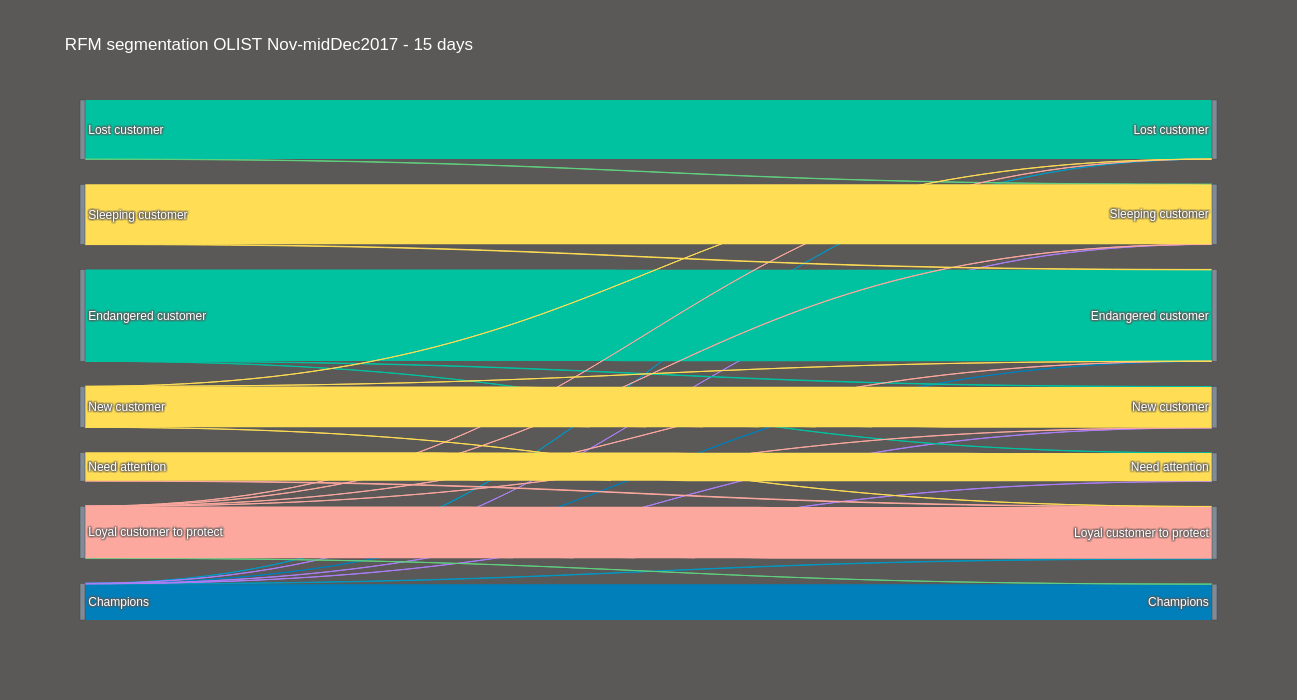

In [151]:
# plot Historical comparison over 15 days
fig_1 = go.Figure(data_1)
fig_1.update_layout(hovermode='x',
                    title="RFM segmentation OLIST Nov-midDec2017 - 15 days",
                    font=dict(size=12, color='white'),
                    paper_bgcolor='#5B5958',
                    width=500, height=700)

fig_1.show()

---
---
<a id='1month_visu'></a>

## <font color = '#0085dd'>Visualization Segments stability 1 month</font>

In [124]:
source_1month = df_sankey_1month["Source"].to_list()
target_1month = df_sankey_1month["Target"].to_list()
value_1month = df_sankey_1month["1month_value"].to_list()

In [152]:
color_link_1m = ['#007fba', '#007fba',
                 '#0098c4', '#0098c4',
                 '#ab7ef5', '#ab7ef5', '#ab7ef5', '#ab7ef5', '#ab7ef5',
                 '#00c2a1', '#00c2a1', '#00c2a1', '#00c2a1', '#00c2a1',
                 '#60d17f', '#60d17f',
                 '#fca89f', '#fca89f', '#fca89f', '#fca89f', '#fca89f',
                 '#fca89f',
                 '#ffdd54', '#ffdd54', '#ffdd54', '#ffdd54', '#ffdd54',
                 '#ffdd54', '#ffdd54']

In [153]:
# Node data
color_node_1m = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96',
                 '#808B96', '#808B96',
                 '#808B96', '#808B96', '#808B96', '#808B96', '#808B96',
                 '#808B96', '#808B96']

In [154]:
# data to dict, dict to sankey
link_1m = dict(source=source_1month, target=target_1month,
               value=value_1month, color=color_link_1m)
node_1m = dict(label=label, pad=25, thickness=5, color=color_node_1m)
data_1m = go.Sankey(link=link_1m, node=node_1m, arrangement='freeform')

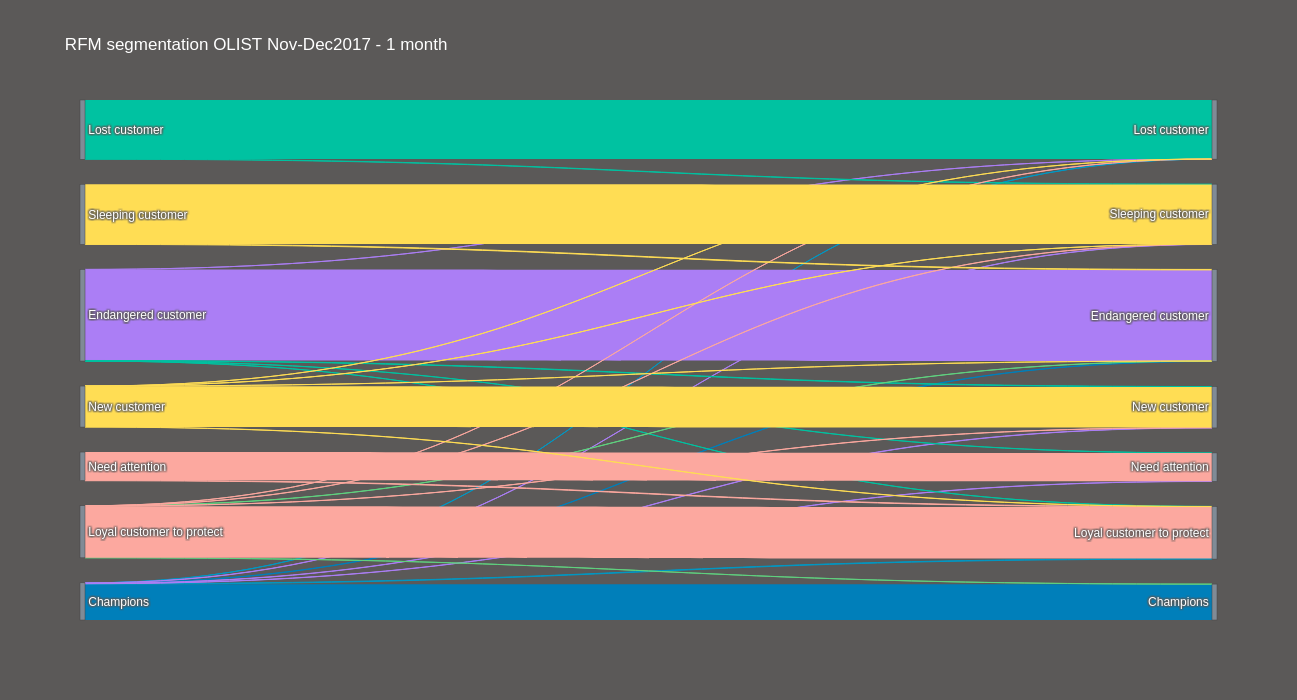

In [155]:
# plot Historical comparison over 1 month
fig_1 = go.Figure(data_1m)
fig_1.update_layout(hovermode='x',
                    title="RFM segmentation OLIST Nov-Dec2017 - 1 month",
                    font=dict(size=12, color='white'),
                    paper_bgcolor='#5B5958',
                    width=500, height=700)

fig_1.show()

---
---
<a id='2month_visu'></a>

## <font color = '#0085dd'>Visualization Segments stability 2 month</font>

In [129]:
source_2month = df_sankey_2month["Source"].to_list()
target_2month = df_sankey_2month["Target"].to_list()
value_2month = df_sankey_2month["2month_value"].to_list()

In [156]:
color_link_2m = ['#007fba', '#007fba',
                 '#0098c4', '#0098c4',
                 '#ab7ef5', '#ab7ef5', '#ab7ef5', '#ab7ef5', '#ab7ef5',
                 '#00c2a1', '#00c2a1', '#00c2a1', '#00c2a1', '#00c2a1',
                 '#00c2a1',
                 '#60d17f', '#60d17f',
                 '#fca89f', '#fca89f', '#fca89f', '#fca89f', '#fca89f',
                 '#fca89f',
                 '#ffdd54', '#ffdd54', '#ffdd54', '#ffdd54', '#ffdd54',
                 '#ffdd54', '#ffdd54']

In [157]:
# Node data
color_node_2m = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96',
                 '#808B96', '#808B96',
                 '#808B96', '#808B96', '#808B96', '#808B96', '#808B96',
                 '#808B96', '#808B96']

In [158]:
# data to dict, dict to sankey
link_2m = dict(source=source_2month, target=target_2month,
               value=value_2month, color=color_link_2m)
node_2m = dict(label=label, pad=25, thickness=5, color=color_node_2m)
data_2m = go.Sankey(link=link_2m, node=node_2m, arrangement='freeform')

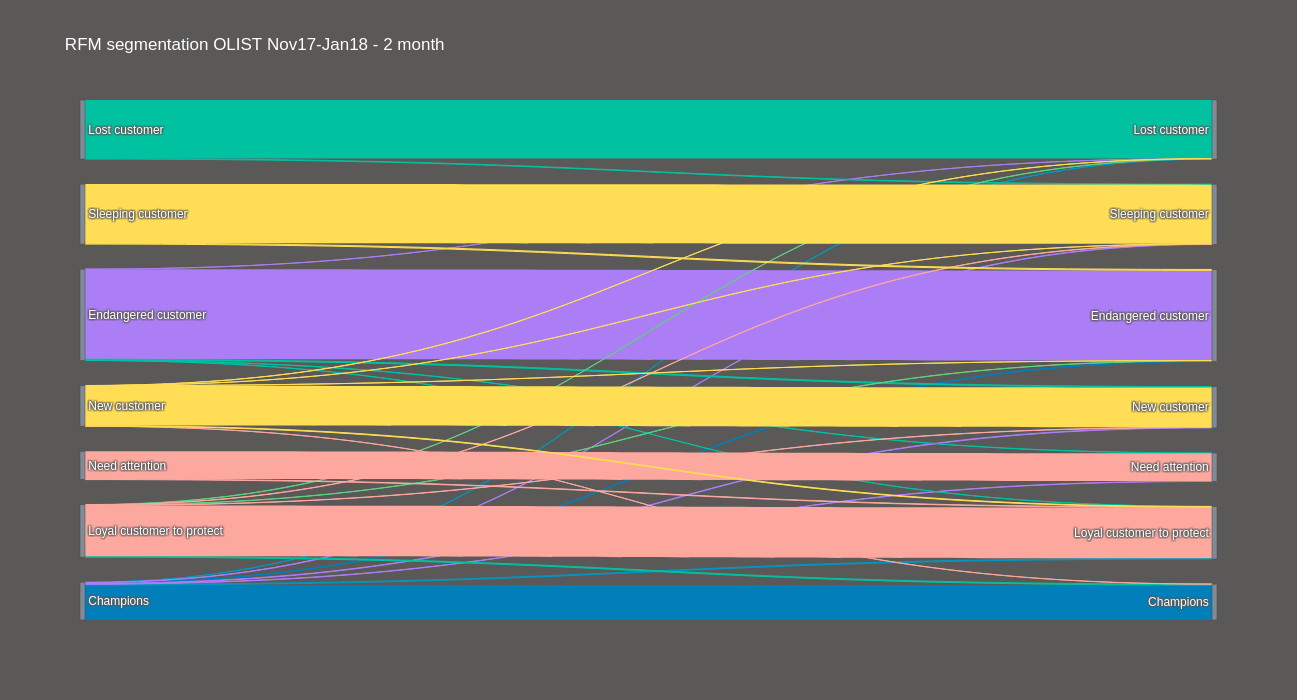

In [159]:
# plot Historical comparison over 2 monts
fig_1 = go.Figure(data_2m)
fig_1.update_layout(hovermode='x',
                    title="RFM segmentation OLIST Nov17-Jan18 - 2 month",
                    font=dict(size=12, color='white'),
                    paper_bgcolor='#5B5958',
                    width=500, height=700)

fig_1.show()

---
---
<a id='3month_visu'></a>

## <font color = '#0085dd'>Visualization Segments stability 3 month</font>

In [134]:
source_3month = df_sankey_3month["Source"].to_list()
target_3month = df_sankey_3month["Target"].to_list()
value_3month = df_sankey_3month["3months_value"].to_list()

In [160]:
color_link_3m = ['#007fba', '#007fba',
                 '#0098c4', '#0098c4',
                 '#ab7ef5', '#ab7ef5', '#ab7ef5', '#ab7ef5', '#ab7ef5',
                 '#ab7ef5',
                 '#00c2a1', '#00c2a1', '#00c2a1', '#00c2a1', '#00c2a1',
                 '#00c2a1',
                 '#60d17f', '#60d17f',
                 '#fca89f', '#fca89f', '#fca89f', '#fca89f', '#fca89f',
                 '#fca89f',
                 '#ffdd54', '#ffdd54', '#ffdd54', '#ffdd54', '#ffdd54',
                 '#ffdd54', '#ffdd54']

In [161]:
# Node data
color_node_3m = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96',
                 '#808B96', '#808B96',
                 '#808B96', '#808B96', '#808B96', '#808B96', '#808B96',
                 '#808B96', '#808B96']

In [162]:
# data to dict, dict to sankey
link_3m = dict(source=source_3month, target=target_3month,
               value=value_3month, color=color_link_3m)
node_3m = dict(label=label, pad=25, thickness=5, color=color_node_3m)
data_3m = go.Sankey(link=link_3m, node=node_3m, arrangement='freeform')

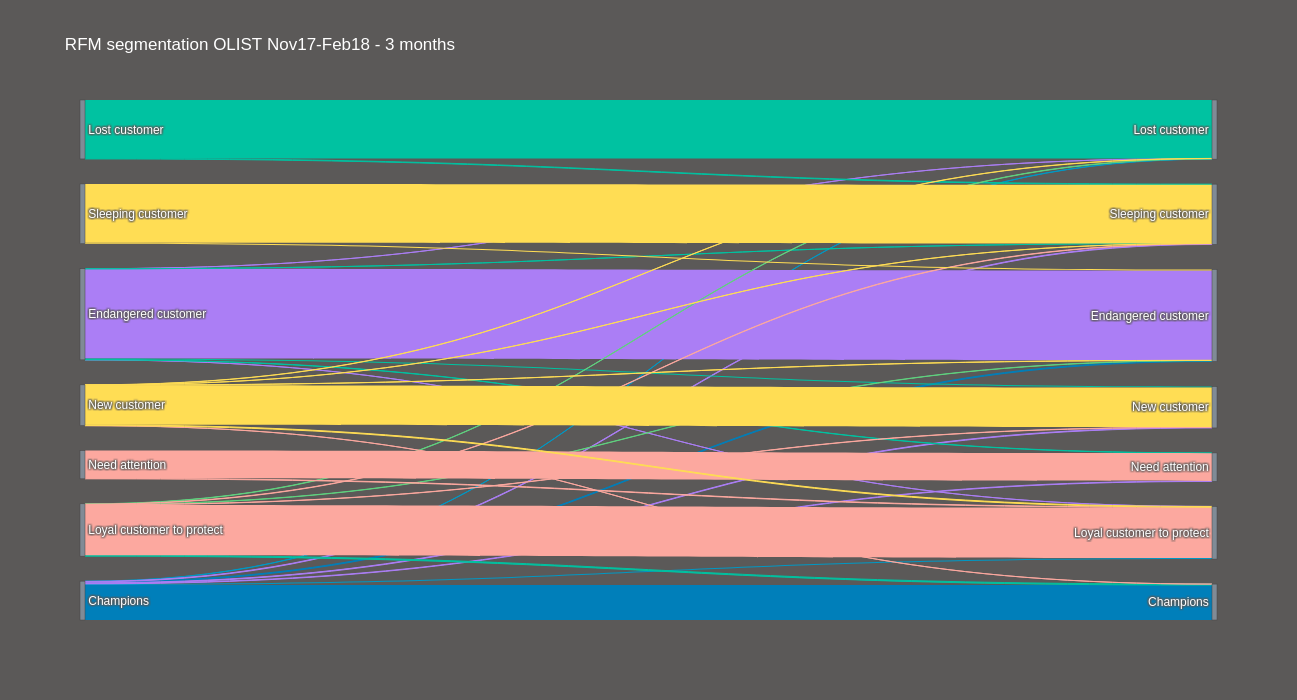

In [163]:
# plot Historical comparison over 3 months
fig_1 = go.Figure(data_3m)
fig_1.update_layout(hovermode='x',
                    title="RFM segmentation OLIST Nov17-Feb18 - 3 months",
                    font=dict(size=12, color='white'),
                    paper_bgcolor='#5B5958',
                    width=500, height=700)

fig_1.show()

---
---
<a id='5month_visu'></a>

## <font color = '#0085dd'>Visualization Segments stability 5 month</font>

In [167]:
source_5month = df_sankey_5month["Source"].to_list()
target_5month = df_sankey_5month["Target"].to_list()
value_5month = df_sankey_5month["5months_value"].to_list()

In [182]:
color_link_5m = ['#007fba', '#007fba', '#007fba',
                 '#0098c4', '#0098c4',
                 '#ab7ef5', '#ab7ef5', '#ab7ef5', '#ab7ef5', '#ab7ef5',
                 '#ab7ef5', '#ab7ef5',
                 '#00c2a1', '#00c2a1', '#00c2a1', '#00c2a1', '#00c2a1',
                 '#00c2a1',
                 '#60d17f', '#60d17f',
                 '#fca89f', '#fca89f', '#fca89f', '#fca89f', '#fca89f',
                 '#fca89f',
                 '#ffdd54', '#ffdd54', '#ffdd54', '#ffdd54', '#ffdd54',
                 '#ffdd54', '#ffdd54']

In [183]:
# Node data
color_node_5m = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96',
                 '#808B96', '#808B96',
                 '#808B96', '#808B96', '#808B96', '#808B96', '#808B96',
                 '#808B96', '#808B96']

In [184]:
# data to dict, dict to sankey
link_5m = dict(source=source_5month, target=target_5month,
               value=value_5month, color=color_link_5m)
node_5m = dict(label=label, pad=25, thickness=5, color=color_node_5m)
data_5m = go.Sankey(link=link_5m, node=node_5m, arrangement='freeform')

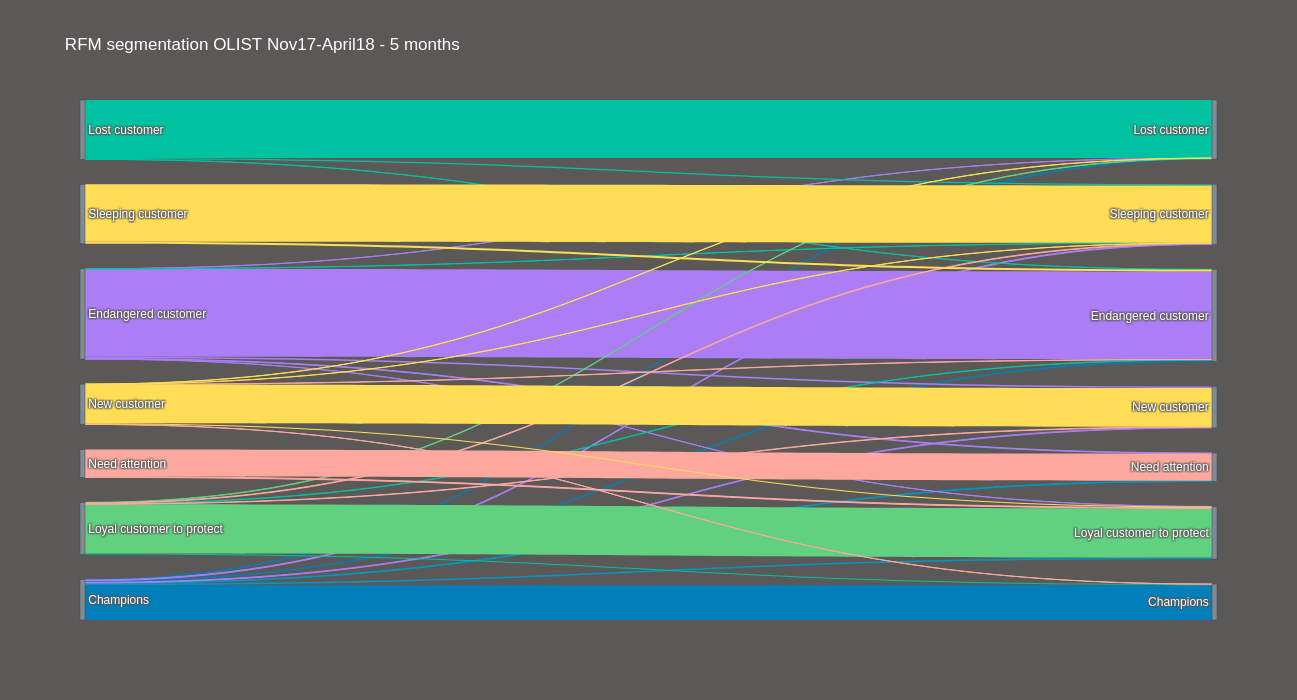

In [185]:
# plot Historical comparison over 5 months
fig_1 = go.Figure(data_5m)
fig_1.update_layout(hovermode='x',
                    title="RFM segmentation OLIST Nov17-April18 - 5 months",
                    font=dict(size=12, color='white'),
                    paper_bgcolor='#5B5958',
                    width=500, height=700)

fig_1.show()

---
---
<a id='6month_visu'></a>

## <font color = '#0085dd'>Visualization Segments stability 6 month</font>

In [172]:
source_6month = df_sankey_6month["Source"].to_list()
target_6month = df_sankey_6month["Target"].to_list()
value_6month = df_sankey_6month["6months_value"].to_list()

In [186]:
color_link_6m = ['#007fba', '#007fba', '#007fba',
                 '#0098c4', '#0098c4', '#0098c4',
                 '#ab7ef5', '#ab7ef5', '#ab7ef5', '#ab7ef5', '#ab7ef5',
                 '#ab7ef5',
                 '#00c2a1', '#00c2a1', '#00c2a1', '#00c2a1', '#00c2a1',
                 '#00c2a1',
                 '#60d17f', '#60d17f',
                 '#fca89f', '#fca89f', '#fca89f', '#fca89f', '#fca89f',
                 '#fca89f',
                 '#ffdd54', '#ffdd54', '#ffdd54', '#ffdd54', '#ffdd54',
                 '#ffdd54', '#ffdd54']

In [187]:
# Node data
color_node_6m = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96',
                 '#808B96', '#808B96',
                 '#808B96', '#808B96', '#808B96', '#808B96', '#808B96',
                 '#808B96', '#808B96']

In [188]:
# data to dict, dict to sankey
link_6m = dict(source=source_6month, target=target_6month,
               value=value_6month, color=color_link_6m)
node_6m = dict(label=label, pad=25, thickness=5, color=color_node_6m)
data_6m = go.Sankey(link=link_6m, node=node_6m, arrangement='freeform')

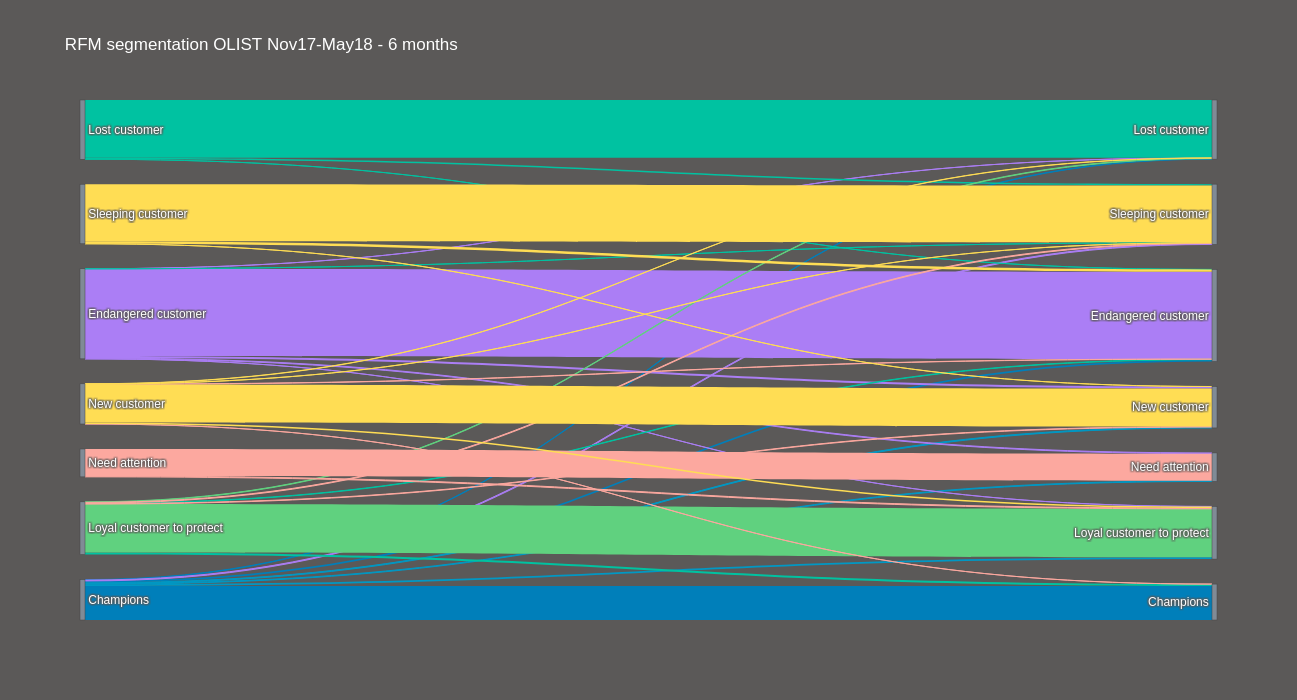

In [189]:
# plot Historical comparison over 6 months
fig_1 = go.Figure(data_6m)
fig_1.update_layout(hovermode='x',
                    title="RFM segmentation OLIST Nov17-May18 - 6 months",
                    font=dict(size=12, color='white'),
                    paper_bgcolor='#5B5958',
                    width=500, height=700)

fig_1.show()

---
---
<a id='9month_visu'></a>

## <font color = '#0085dd'>Visualization Segments stability 9 month</font>

In [177]:
source_9month = df_sankey_9month["Source"].to_list()
target_9month = df_sankey_9month["Target"].to_list()
value_9month = df_sankey_9month["9months_value"].to_list()

In [190]:
color_link_9m = ['#007fba', '#007fba', '#007fba',
                 '#0098c4', '#0098c4', '#0098c4',
                 '#ab7ef5', '#ab7ef5', '#ab7ef5', '#ab7ef5', '#ab7ef5',
                 '#00c2a1', '#00c2a1', '#00c2a1', '#00c2a1', '#00c2a1',
                 '#00c2a1',
                 '#60d17f', '#60d17f',
                 '#fca89f', '#fca89f', '#fca89f', '#fca89f', '#fca89f',
                 '#fca89f',
                 '#ffdd54', '#ffdd54', '#ffdd54', '#ffdd54', '#ffdd54',
                 '#ffdd54', '#ffdd54']

In [191]:
# Node data
color_node_9m = ['#808B96', '#808B96', '#808B96', '#808B96', '#808B96',
                 '#808B96', '#808B96',
                 '#808B96', '#808B96', '#808B96', '#808B96', '#808B96',
                 '#808B96', '#808B96']

In [192]:
# data to dict, dict to sankey
link_9m = dict(source=source_9month, target=target_9month,
               value=value_9month, color=color_link_9m)
node_9m = dict(label=label, pad=25, thickness=5, color=color_node_9m)
data_9m = go.Sankey(link=link_9m, node=node_9m, arrangement='freeform')

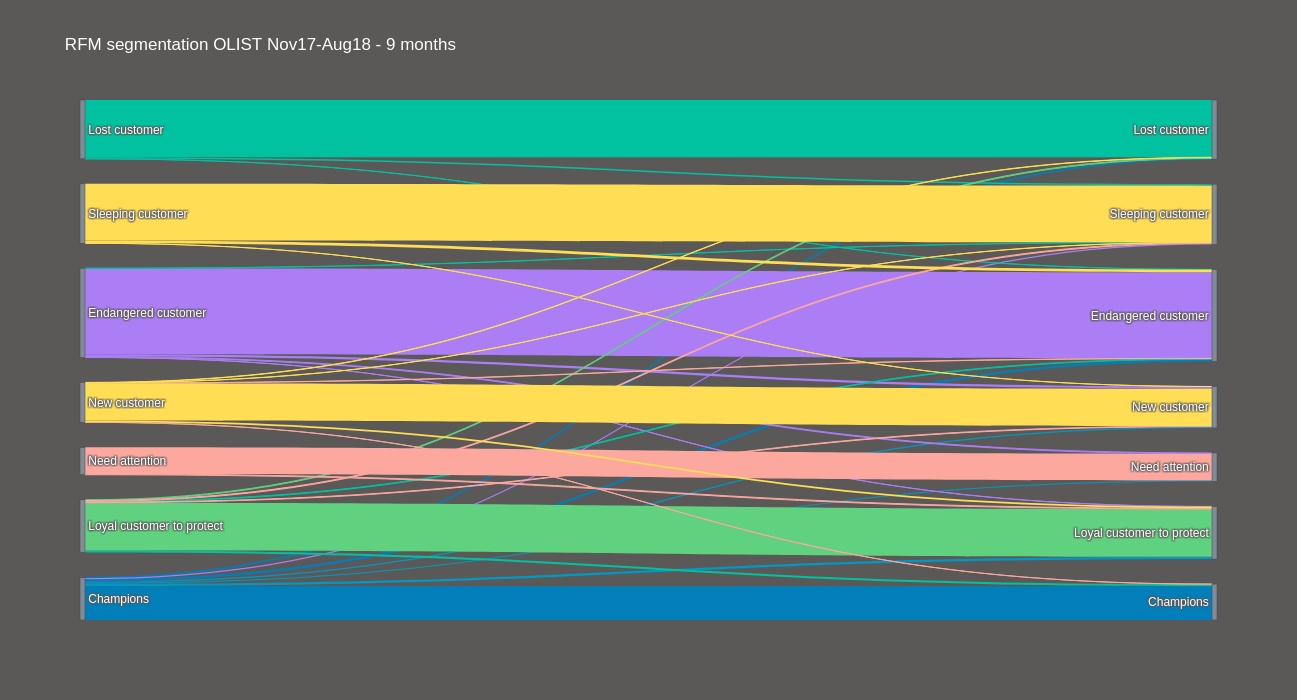

In [193]:
# plot Historical comparison over 9 months
fig_1 = go.Figure(data_9m)
fig_1.update_layout(hovermode='x',
                    title="RFM segmentation OLIST Nov17-Aug18 - 9 months",
                    font=dict(size=12, color='white'),
                    paper_bgcolor='#5B5958',
                    width=500, height=700)

fig_1.show()